# Milestone 1 Assignment - Capstone Proposal

## Author - Connor Higgins

## Problem Definition



<img align='right' style="padding:10px" src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/73/Energy_Star_logo.svg/250px-Energy_Star_logo.svg.png"> <p>An up and coming Seattle developer is interested in creating sustainable and eco-friendly office and public buildings, at least with respect to their competitor's efforts. One measure of energy performance, the Energy Star Score, is a key metric with which they hope to distinguish themselves from the local competition. Created by EPA's <i>ENERGY STAR</i>, a program whose goal is to help businesses with energy efficiency, the Energy Star Score is a rating (1-100) that compares the energy comsumption of similar buildings across the U.S. By earning a score of 75 or above for 12 consecutive months, buildings can earn an Energy Star certification. In 2017, the city with the most Energy Star certified buildings was Los Angeles, with a grand total of 716. In comparison, Seattle, ranked 13th overall, had only 164 certified buildings (<a href="https://www.energystar.gov/buildings/topcities">Source</a>).</p>

<p>To maximize the potential of earning Energy Stars for newly constructed buildings, this Seattle developer would like us to look through past Energy Star data to determine which building attributes are most important for acheiving a high overall score. Furthermore, they are interested in whether the importance of particular attributes changes with respect to time (year evaluated) and city. Last, they are hoping that a machine learning model can be used to predict Energy Star scores in the form of a regression problem, or whether it can be used to predict score quintile in the form of a multi-classification problem.</p>

<p>To effectively answer these questions, we looked at three Energy Star benchmarking datasets: two Seattle-based datasets (2015, 2016) and one Chicago-based (2014-2016) dataset. After data preparation, we can utilize the two Seattle datasets to determine whether the weight of each feature contributing to the Energy Star model's performance changes with respect to year (2015 v. 2016). Subsequently, we can then compare both the 2015 and 2016 Seattle data to the Chicago 2014-2016 data to determine whether feature weights vary based on city. Finally, all data or individual datasets can be fitted to either a regression or classification model to predict Energy Star score or score quintile respectively.</p>

## Data Sets

In [1]:
# Datasets location
sea_energy_2015_file = ("https://raw.githubusercontent.com/connor1higgins/Projects/master/UWDataScience/PartIII/"
                        "2015-building-energy-benchmarking.csv")
# source: https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking
sea_energy_2016_file = ("https://raw.githubusercontent.com/connor1higgins/Projects/master/UWDataScience/PartIII/"
                        "2016-building-energy-benchmarking.csv")
# source: https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking
chicago_energy_file = ("https://raw.githubusercontent.com/connor1higgins/Projects/master/UWDataScience/PartIII/"
                       "Chicago_Energy_Benchmarking.csv")
# source: https://catalog.data.gov/dataset/chicago-energy-benchmarking

Both Seattle datasets were found on Kaggle (<a href="https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking">Source</a>) and were provided as part of a mandate the Seattle City Council passed in 2016, making the data for all buildings 20,000 square feet and larger available annually. Reportedly, both datasets represent nearly a third of Seattle's annual emissions. 

The Chicago dataset was found on the US goverment's open data website (<a href="https://catalog.data.gov/dataset/chicago-energy-benchmarking">Source</a>) and was similarly provided through a law passed by Chicago city council, wherein buildings greater than 50,000 square feet are to track and annually report whole-building energy use. Reportedly, this dataset represents a fifth of Chicago's annual emissions.

## Profile Reports & Analysis Statements

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# Reading .csv files as DataFrames
df_sea2015 = pd.read_csv(sea_energy_2015_file)
df_sea2016 = pd.read_csv(sea_energy_2016_file)
df_chicago = pd.read_csv(chicago_energy_file)

### Seattle Building Energy Benchmarking 2015 Dataset

#### Initial Cleaning

In [4]:
# Removing known outliers from dataset
df_sea2015['Outlier'] = df_sea2015['Outlier'].astype(str)
df_sea2015 = df_sea2015[~df_sea2015['Outlier'].str.contains('Outlier')]
# Removing entries without SiteEnergyUseWN(kBtu) values
df_sea2015 = df_sea2015[~df_sea2015['SiteEnergyUseWN(kBtu)'].isnull()]
# Removing entries without recorded ENERGYSTARScore values
df_sea2015 = df_sea2015[~df_sea2015['ENERGYSTARScore'].isnull()]
df_sea2015.reset_index(inplace=True, drop=True)

# Converting 'DataYear' feature from int dtype to str
df_sea2015['DataYear'] = df_sea2015['DataYear'].astype(str)

# Removing newline characters from PrimaryPropertyType values
df_sea2015['PrimaryPropertyType'] = df_sea2015['PrimaryPropertyType'].str.replace('\n', '')

# Separating Location feature into Latitude and Longitude features
import json
df_sea2015['Location'] = df_sea2015['Location'].str.split('human').str[0]
df_sea2015['Location'] = df_sea2015['Location'].str.slice(stop=-3) + '}'
df_sea2015['Location'] = df_sea2015['Location'].str.replace("\'", "\"")
loclist = df_sea2015['Location'].tolist()
loclist = [json.loads(string) for string in loclist]
df_sea2015locs = pd.DataFrame(loclist)
df_sea2015locs['latitude'] = df_sea2015locs['latitude'].astype(float)
df_sea2015locs['longitude'] = df_sea2015locs['longitude'].astype(float)
df_sea2015 = pd.concat([df_sea2015, df_sea2015locs], axis=1)
df_sea2015.rename(index=str, columns={'latitude':'Latitude',
                                      'longitude': 'Longitude'}, inplace=True)

# Converting ENERGYSTARScore feature into categorical variable: ENERGYSTARQuintile
bins = [0, 20, 40, 60, 80, np.inf]
names = ['quin0', 'quin1', 'quin2', 'quin3', 'quin4']
df_sea2015['ENERGYSTARQuintile'] = pd.cut(df_sea2015['ENERGYSTARScore'], bins, labels=names)

print(df_sea2015.info())
df_sea2015.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 2491 entries, 0 to 2490
Data columns (total 45 columns):
OSEBuildingID                        2491 non-null int64
DataYear                             2491 non-null object
BuildingType                         2491 non-null object
PrimaryPropertyType                  2491 non-null object
PropertyName                         2491 non-null object
TaxParcelIdentificationNumber        2490 non-null object
Location                             2491 non-null object
CouncilDistrictCode                  2491 non-null int64
Neighborhood                         2491 non-null object
YearBuilt                            2491 non-null int64
NumberofBuildings                    2491 non-null int64
NumberofFloors                       2488 non-null float64
PropertyGFATotal                     2491 non-null int64
PropertyGFAParking                   2491 non-null int64
PropertyGFABuilding(s)               2491 non-null int64
ListOfAllPropertyUseTypes         

OSEBuildingID  CouncilDistrictCode    YearBuilt  NumberofBuildings  \
count    2491.000000          2491.000000  2491.000000        2491.000000   
mean    20546.177439             4.472100  1969.331192           1.007226   
std     11535.921565             2.094822    31.784476           0.167512   
min         1.000000             1.000000  1900.000000           1.000000   
25%     19961.500000             3.000000  1952.500000           1.000000   
50%     22971.000000             4.000000  1976.000000           1.000000   
75%     25756.000000             7.000000  1995.000000           1.000000   
max     50059.000000             7.000000  2015.000000           7.000000   

       NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
count     2488.000000      2.491000e+03         2491.000000   
mean         5.044212      9.454294e+04        11734.242473   
std          6.032453      1.507192e+05        35185.219242   
min          0.000000      2.000000e+04           -3.000000   
25%          3.000000      2.953050e+04            0.000000   
50%          4.000000      4.618400e+04            0.000000   
75%          5.000000      9.310050e+04         5828.000000   
max         99.000000      1.952220e+06       512608.000000   

       PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
count            2.491000e+03               2.384000e+03   
mean             8.280870e+04               7.875708e+04   
std              1.289234e+05               1.231968e+05   
min             -4.331000e+04               8.061000e+03   
25%              2.756350e+04               2.656600e+04   
50%              4.342200e+04               4.161950e+04   
75%              8.306300e+04               7.855350e+04   
max              1.765970e+06               1.680937e+06   

       SecondLargestPropertyUseTypeGFA     ...       SteamUse(kBtu)  \
count                      1019.000000     ...         2.491000e+03   
mean                      31923.046124     ...         2.361948e+05   
std                       54547.444916     ...         3.846033e+06   
min                           0.000000     ...         0.000000e+00   
25%                        6000.000000     ...         0.000000e+00   
50%                       13049.000000     ...         0.000000e+00   
75%                       32245.500000     ...         0.000000e+00   
max                      441551.000000     ...         1.278697e+08   

       Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
count      2.491000e+03       2.491000e+03        2.491000e+03   
mean       9.842925e+05       3.358545e+06        1.110987e+04   
std        2.889590e+06       9.859692e+06        4.130191e+04   
min        3.101000e+03       1.058000e+04        0.000000e+00   
25%        1.939850e+05       6.619035e+05        0.000000e+00   
50%        3.448150e+05       1.176558e+06        2.597000e+03   
75%        7.856480e+05       2.680742e+06        1.054800e+04   
max        8.344505e+07       2.847263e+08        1.364484e+06   

       NaturalGas(kBtu)  OtherFuelUse(kBtu)  GHGEmissions(MetricTonsCO2e)  \
count      2.491000e+03        2.491000e+03                   2491.000000   
mean       1.110987e+06        1.841630e+03                    100.648659   
std        4.130191e+06        6.055389e+04                    424.979381   
min        0.000000e+00        0.000000e+00                      0.350000   
25%        0.000000e+00        0.000000e+00                      8.810000   
50%        2.597360e+05        0.000000e+00                     30.190000   
75%        1.054765e+06        0.000000e+00                     82.355000   
max        1.364484e+08        2.304567e+06                  11824.890000   

       GHGEmissionsIntensity(kgCO2e/ft2)     Latitude    Longitude  
count                        2491.000000  2491.000000  2491.000000  
mean                            0.817310    47.625640  -122.334671  
std                             1.192336     0.048712     0.027351  

The Seattle 2015 building energy benchmarking dataset originally consisted of 3340 entries with 42 attributes. Of this set, 2% were classified as outliers by the original curators of the dataset. Moreover, 23% (780) of entries were missing ENERGYSTARScore values. Removing these entries, creating a cateogrical target, ENERGYSTARQuintile, from binning ENERGYSTARScore, and expanding the location feature into latitude and longitude features results in a dataset with 2491 entries and 45 attributes.

#### Initial Data Exploration

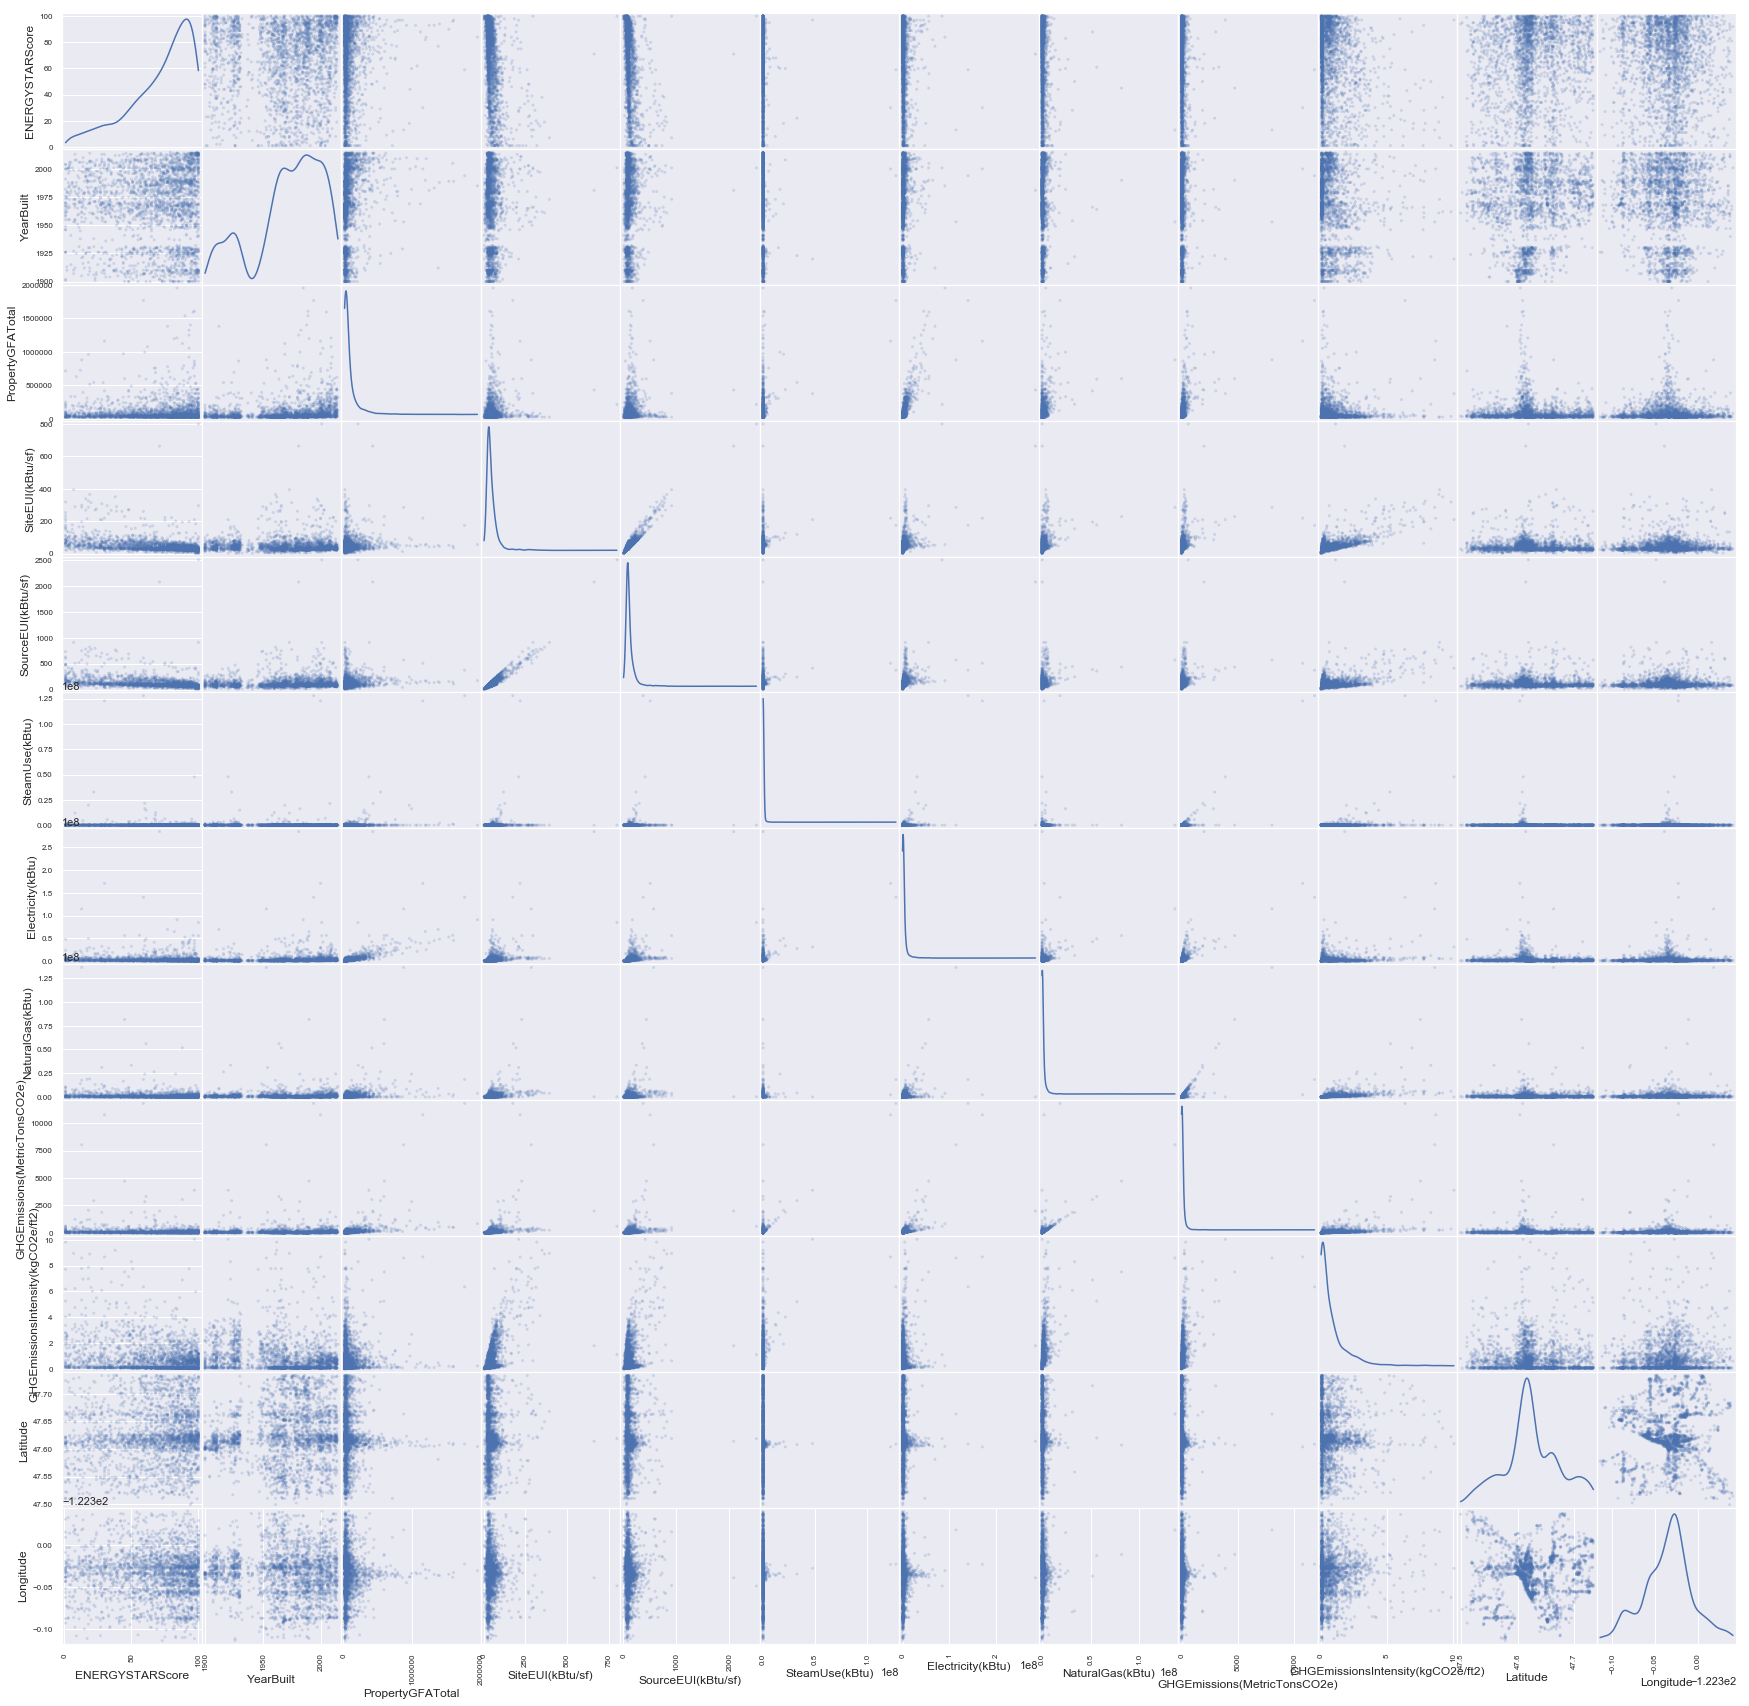

ENERGYSTARScore  YearBuilt  \
ENERGYSTARScore                           1.000000   0.011099   
YearBuilt                                 0.011099   1.000000   
PropertyGFATotal                          0.058081   0.184802   
SiteEUI(kBtu/sf)                         -0.352760  -0.008254   
SourceEUI(kBtu/sf)                       -0.339495   0.069676   
SteamUse(kBtu)                           -0.033676  -0.000355   
Electricity(kBtu)                        -0.054623   0.096546   
NaturalGas(kBtu)                         -0.099524   0.010753   
GHGEmissions(MetricTonsCO2e)             -0.083728   0.020917   
GHGEmissionsIntensity(kgCO2e/ft2)        -0.233144  -0.210711   
Latitude                                  0.102531   0.111741   
Longitude                                -0.055889  -0.070068   

                                   PropertyGFATotal  SiteEUI(kBtu/sf)  \
ENERGYSTARScore                            0.058081         -0.352760   
YearBuilt                                  0.184802         -0.008254   
PropertyGFATotal                           1.000000          0.136708   
SiteEUI(kBtu/sf)                           0.136708          1.000000   
SourceEUI(kBtu/sf)                         0.153185          0.952492   
SteamUse(kBtu)                             0.308106          0.138311   
Electricity(kBtu)                          0.691367          0.471868   
NaturalGas(kBtu)                           0.326997          0.334266   
GHGEmissions(MetricTonsCO2e)               0.495822          0.345465   
GHGEmissionsIntensity(kgCO2e/ft2)          0.049823          0.672263   
Latitude                                  -0.058024         -0.010998   
Longitude                                  0.016704          0.032383   

                                   SourceEUI(kBtu/sf)  SteamUse(kBtu)  \
ENERGYSTARScore                             -0.339495       -0.033676   
YearBuilt                                    0.069676       -0.000355   
PropertyGFATotal                             0.153185        0.308106   
SiteEUI(kBtu/sf)                             0.952492        0.138311   
SourceEUI(kBtu/sf)                           1.000000        0.111178   
SteamUse(kBtu)                               0.111178        1.000000   
Electricity(kBtu)                            0.529449        0.465713   
NaturalGas(kBtu)                             0.218628        0.071888   
GHGEmissions(MetricTonsCO2e)                 0.276137        0.810971   
GHGEmissionsIntensity(kgCO2e/ft2)            0.430888        0.236475   
Latitude                                    -0.001021       -0.022442   
Longitude                                    0.015700        0.014433   

                                   Electricity(kBtu)  NaturalGas(kBtu)  \
ENERGYSTARScore                            -0.054623         -0.099524   
YearBuilt                                   0.096546          0.010753   
PropertyGFATotal                            0.691367          0.326997   
SiteEUI(kBtu/sf)                            0.471868          0.334266   
SourceEUI(kBtu/sf)                          0.529449          0.218628   
SteamUse(kBtu)                              0.465713          0.071888   
Electricity(kBtu)                           1.000000          0.373710   
NaturalGas(kBtu)                            0.373710          1.000000   
GHGEmissions(MetricTonsCO2e)                0.679945          0.626811   
GHGEmissionsIntensity(kgCO2e/ft2)           0.180888          0.455250   
Latitude                                   -0.039948          0.004711   
Longitude                                   0.016448          0.047181   

                                   GHGEmissions(MetricTonsCO2e)  \
ENERGYSTARScore                                       -0.083728   
YearBuilt                                              0.020917   
PropertyGFATotal                                       0.495822   
SiteEUI(kBtu/sf)                                       0.3

In [5]:
# Visualizing numeric features using scatter matrix, alongside correlations
from pandas.plotting import scatter_matrix

dfnumeric_sea2015 = df_sea2015[['ENERGYSTARScore', 'YearBuilt', 
                                'PropertyGFATotal', 'SiteEUI(kBtu/sf)',
                                'SourceEUI(kBtu/sf)', 'SteamUse(kBtu)',
                                'Electricity(kBtu)', 'NaturalGas(kBtu)', 
                                'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
                                'Latitude', 'Longitude']]

scatter_matrix(dfnumeric_sea2015, alpha=0.2, figsize=(30, 30), diagonal='kde')
plt.show()
dfnumeric_sea2015.corr()

Based on the numeric attributes from df_sea2015, ENERGYSTARScore has a moderate negative correlation with both Site Energy Use Intensity (SiteEUI, -0.353) and Source Energy Use Intensity (SourceEUI, -0.339). SiteEUI is calculated as a building's overall Energy Use with respect to utility usage divided by its gross floor area. SourceEUI is similarly calculated, yet is done so with respect to the annual energy used to operate the property, including any energy loss during generation or transmission. Both features are strongly correlated with one another (0.952). 

Greenhouse Gas Emissions Intensity (GHGEmissionsIntensity), calculated as the total Greenhouse Gas Emissions divided by the property's gross floor area, was also slightly negatively correlated with ENERGYSTARScore (-0.233).

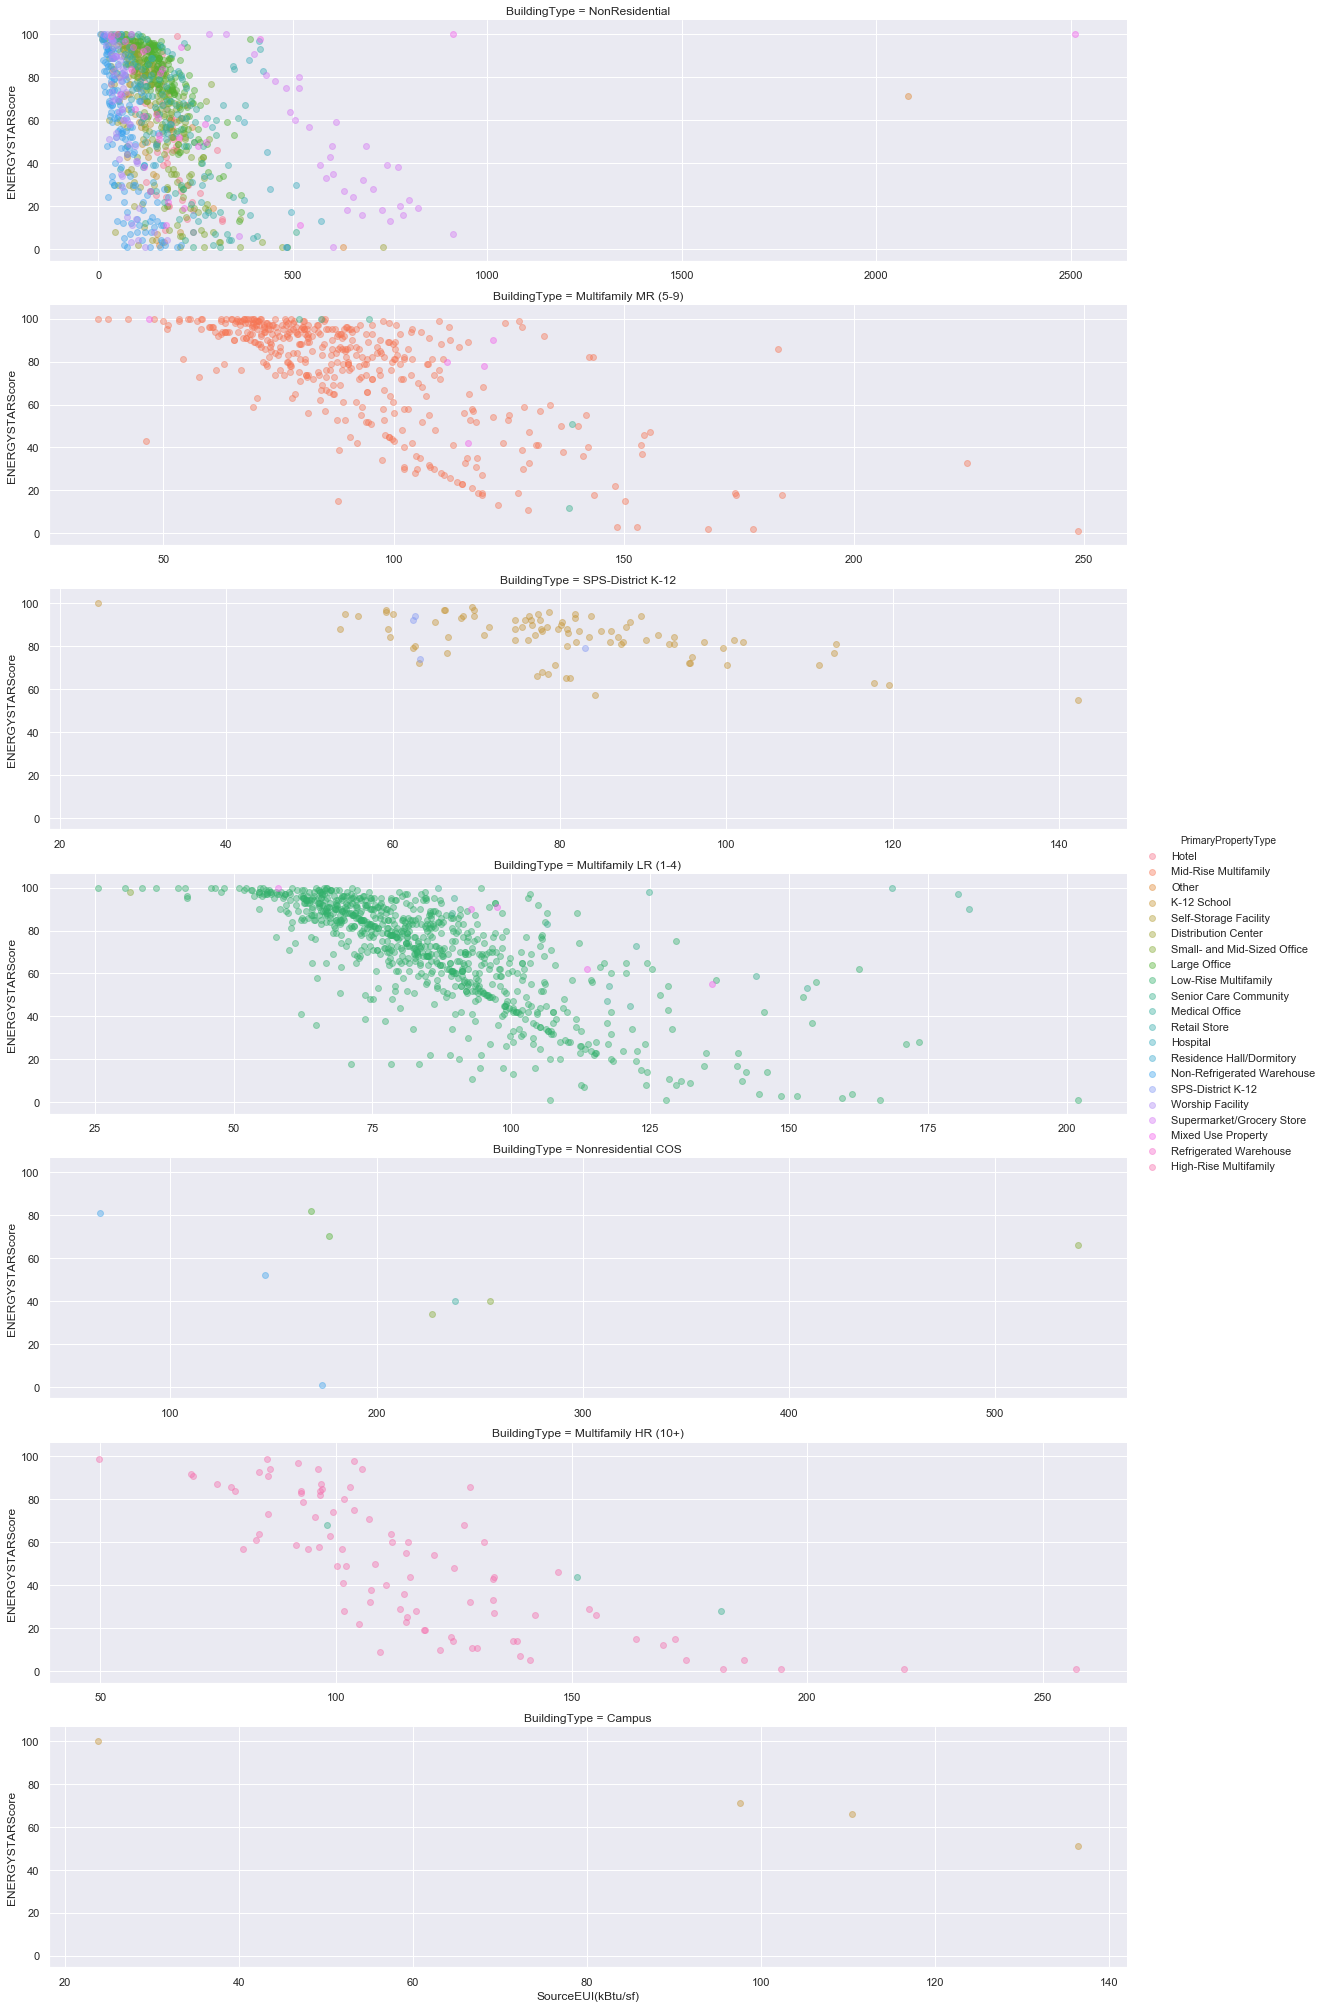

In [6]:
# Visualizing categorical features using facet-grid of BuildingType (rows) and PrimaryPropertyType (hue)
c = sns.FacetGrid(df_sea2015, row="BuildingType", hue="PrimaryPropertyType",
                  height=4, aspect=4, sharex=False)
c = c.map(plt.scatter, "SourceEUI(kBtu/sf)", "ENERGYSTARScore", alpha=0.4).add_legend()
plt.show()

Per previous correlation results, SourceEUI's relationship with ENERGYSTARScore was investigated more thoroughly using two categorical building attributes: BuildingType and PrimaryPropertyType. BuildingType is a general category that the City of Seattle uses to classify buildings, with 43% of entries being NonResidential, 30% Multifamily Low-Rise, 17% Multifamily Mid-Rise, 3% High-Rise, and 6% Other (Campus, SPS-District K-12, Nonresidential COS). PrimaryPropertyType is the primary (i.e. majority) use of a property. This is a more diverse feature, with 24 categories. 

A FacetGrid was created for SourceEUI v. ENERGYSTARScore, with rows representing BuildingType and the hue of the points representing PrimaryPropertyType. For some categories, such as the Multifamily categories, the PrimaryPropertyType is nearly identical. In contrast, NonResidential contains a number of PrimaryPropertyTypes.

The most striking observation is for both Multifamily MR and LR, where there are noticable traces within the larger set of data points. These traces have a shape not unlike that of a cumulative distribution function, with legs at scores 100 and 0 spanning long sections of the domain while a more linear relationship is apparent between extrema. As ENERGYSTARScores are calculated by comparing a building's energy usage with other similar buildings, it would make sense that that values would be partially spread in this manner. What is not clear is why much of the data does not follow this trend at all, instead straying far to the left or right from the location of the trace. Perhaps this can be explained by other features, such as GHGEmissionsIntensity.

### Seattle Building Energy Benchmarking 2016 Dataset
#### Initial Cleaning

In [7]:
# Removing known outliers from dataset
df_sea2016['Outlier'] = df_sea2016['Outlier'].astype(str)
df_sea2016 = df_sea2016[~df_sea2016['Outlier'].str.contains('outlier')]
# Removing entries without recorded ENERGYSTARScore values
df_sea2016 = df_sea2016[~df_sea2016['ENERGYSTARScore'].isnull()]
df_sea2016.reset_index(inplace=True, drop=True)

# Converting 'DataYear' feature from int dtype to str
df_sea2016['DataYear'] = df_sea2016['DataYear'].astype(str)

# Renaming several features to match df_sea2015
df_sea2016.rename(index=str, columns={'GHGEmissionsIntensity':'GHGEmissionsIntensity(kgCO2e/ft2)',
                                      'TotalGHGEmissions': 'GHGEmissions(MetricTonsCO2e)'}, inplace=True)

# Renaming several PrimaryPropertyType values to match df_sea2015
conv = {'Warehouse': 'Non-Refrigerated Warehouse',
        'Supermarket / Grocery Store': 'Supermarket/Grocery Store',
        'Office': 'Small- and Mid-Sized Office',
        'Residence Hall': 'Residence Hall/Dormitory'}
df_sea2016['PrimaryPropertyType'].replace(conv, inplace=True)

# Converting ENERGYSTARScore feature into categorical variable: ENERGYSTARQuintile
bins = [0, 20, 40, 60, 80, np.inf]
names = ['quin0', 'quin1', 'quin2', 'quin3', 'quin4']
df_sea2016['ENERGYSTARQuintile'] = pd.cut(df_sea2016['ENERGYSTARScore'], bins, labels=names)

print(df_sea2016.info())
df_sea2016.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 2510 entries, 0 to 2509
Data columns (total 47 columns):
OSEBuildingID                        2510 non-null int64
DataYear                             2510 non-null object
BuildingType                         2510 non-null object
PrimaryPropertyType                  2510 non-null object
PropertyName                         2510 non-null object
Address                              2510 non-null object
City                                 2510 non-null object
State                                2510 non-null object
ZipCode                              2507 non-null float64
TaxParcelIdentificationNumber        2510 non-null object
CouncilDistrictCode                  2510 non-null int64
Neighborhood                         2510 non-null object
Latitude                             2510 non-null float64
Longitude                            2510 non-null float64
YearBuilt                            2510 non-null int64
NumberofBuildings           

OSEBuildingID       ZipCode  CouncilDistrictCode     Latitude  \
count    2510.000000   2507.000000          2510.000000  2510.000000   
mean    21304.762550  98117.129637             4.475299    47.625459   
std     12149.332987     18.815851             2.091945     0.048285   
min         1.000000  98012.000000             1.000000    47.499170   
25%     20039.750000  98105.000000             3.000000    47.602470   
50%     23163.000000  98115.000000             4.000000    47.619835   
75%     26025.750000  98122.000000             7.000000    47.658415   
max     50222.000000  98272.000000             7.000000    47.733870   

         Longitude    YearBuilt  NumberofBuildings  NumberofFloors  \
count  2510.000000  2510.000000        2510.000000     2510.000000   
mean   -122.334532  1970.010757           1.042629        5.118725   
std       0.027451    32.187280           0.599734        6.057076   
min    -122.414250  1900.000000           0.000000        0.000000   
25%    -122.351168  1953.000000           1.000000        3.000000   
50%    -122.332305  1976.500000           1.000000        4.000000   
75%    -122.318998  1997.000000           1.000000        6.000000   
max    -122.220966  2015.000000          16.000000       99.000000   

       PropertyGFATotal  PropertyGFAParking  \
count      2.510000e+03         2510.000000   
mean       9.690143e+04         8516.518725   
std        1.522003e+05        33331.502277   
min        1.229400e+04            0.000000   
25%        3.003550e+04            0.000000   
50%        4.671050e+04            0.000000   
75%        9.583875e+04            0.000000   
max        1.952220e+06       512608.000000   

                     ...                  SiteEnergyUse(kBtu)  \
count                ...                         2.510000e+03   
mean                 ...                         5.067722e+06   
std                  ...                         1.679329e+07   
min                  ...                         0.000000e+00   
25%                  ...                         9.589367e+05   
50%                  ...                         1.807103e+06   
75%                  ...                         4.130552e+06   
max                  ...                         4.483853e+08   

       SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  \
count           2.509000e+03    2.510000e+03      2.510000e+03   
mean            5.206183e+06    2.574235e+05      1.026935e+06   
std             1.717261e+07    4.091425e+06      3.014682e+06   
min             0.000000e+00    0.000000e+00     -3.382680e+04   
25%             1.011670e+06    0.000000e+00      1.967723e+05   
50%             1.908058e+06    0.000000e+00      3.507079e+05   
75%             4.305973e+06    0.000000e+00      8.236800e+05   
max             4.716139e+08    1.349435e+08      8.046087e+07   

       Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  Comments  \
count       2.510000e+03        2.510000e+03      2.510000e+03       0.0   
mean        3.503903e+06        1.290651e+04      1.290651e+06       NaN   
std         1.028609e+07        7.253126e+04      7.253126e+06       NaN   
min        -1.154170e+05        0.000000e+00      0.000000e+00       NaN   
25%         6.713868e+05        0.000000e+00      0.000000e+00       NaN   
50%         1.196615e+06        3.043290e+03      3.043290e+05       NaN   
75%         2.810396e+06        1.173178e+04      1.173178e+06       NaN   
max         2.745325e+08        2.979090e+06      2.979090e+08       NaN   

       GHGEmissions(MetricTonsCO2e)  GHGEmissionsIntensity(kgCO2e/ft2)  
count                   2510.000000                        2510.000000  
mean                     112.843478                           1.008418  
std                      554.351576                           1.468834  
min                       -0.800000                          -0.020000  
25%                        9.210000                           0.200000  

The Seattle 2016 building energy benchmarking dataset originally consisted of 3376 entries with 46 attributes. Of this set, roughly 1% of entries were classified as outliers by the original curators. Moreover, 25% (835) of entries were missing ENERGYSTARScore values. Removing these entries and creating the categorical target, ENERGYSTARQuintile, results in a dataset with 2510 entries and 47 attributes.

#### Initial Data Exploration

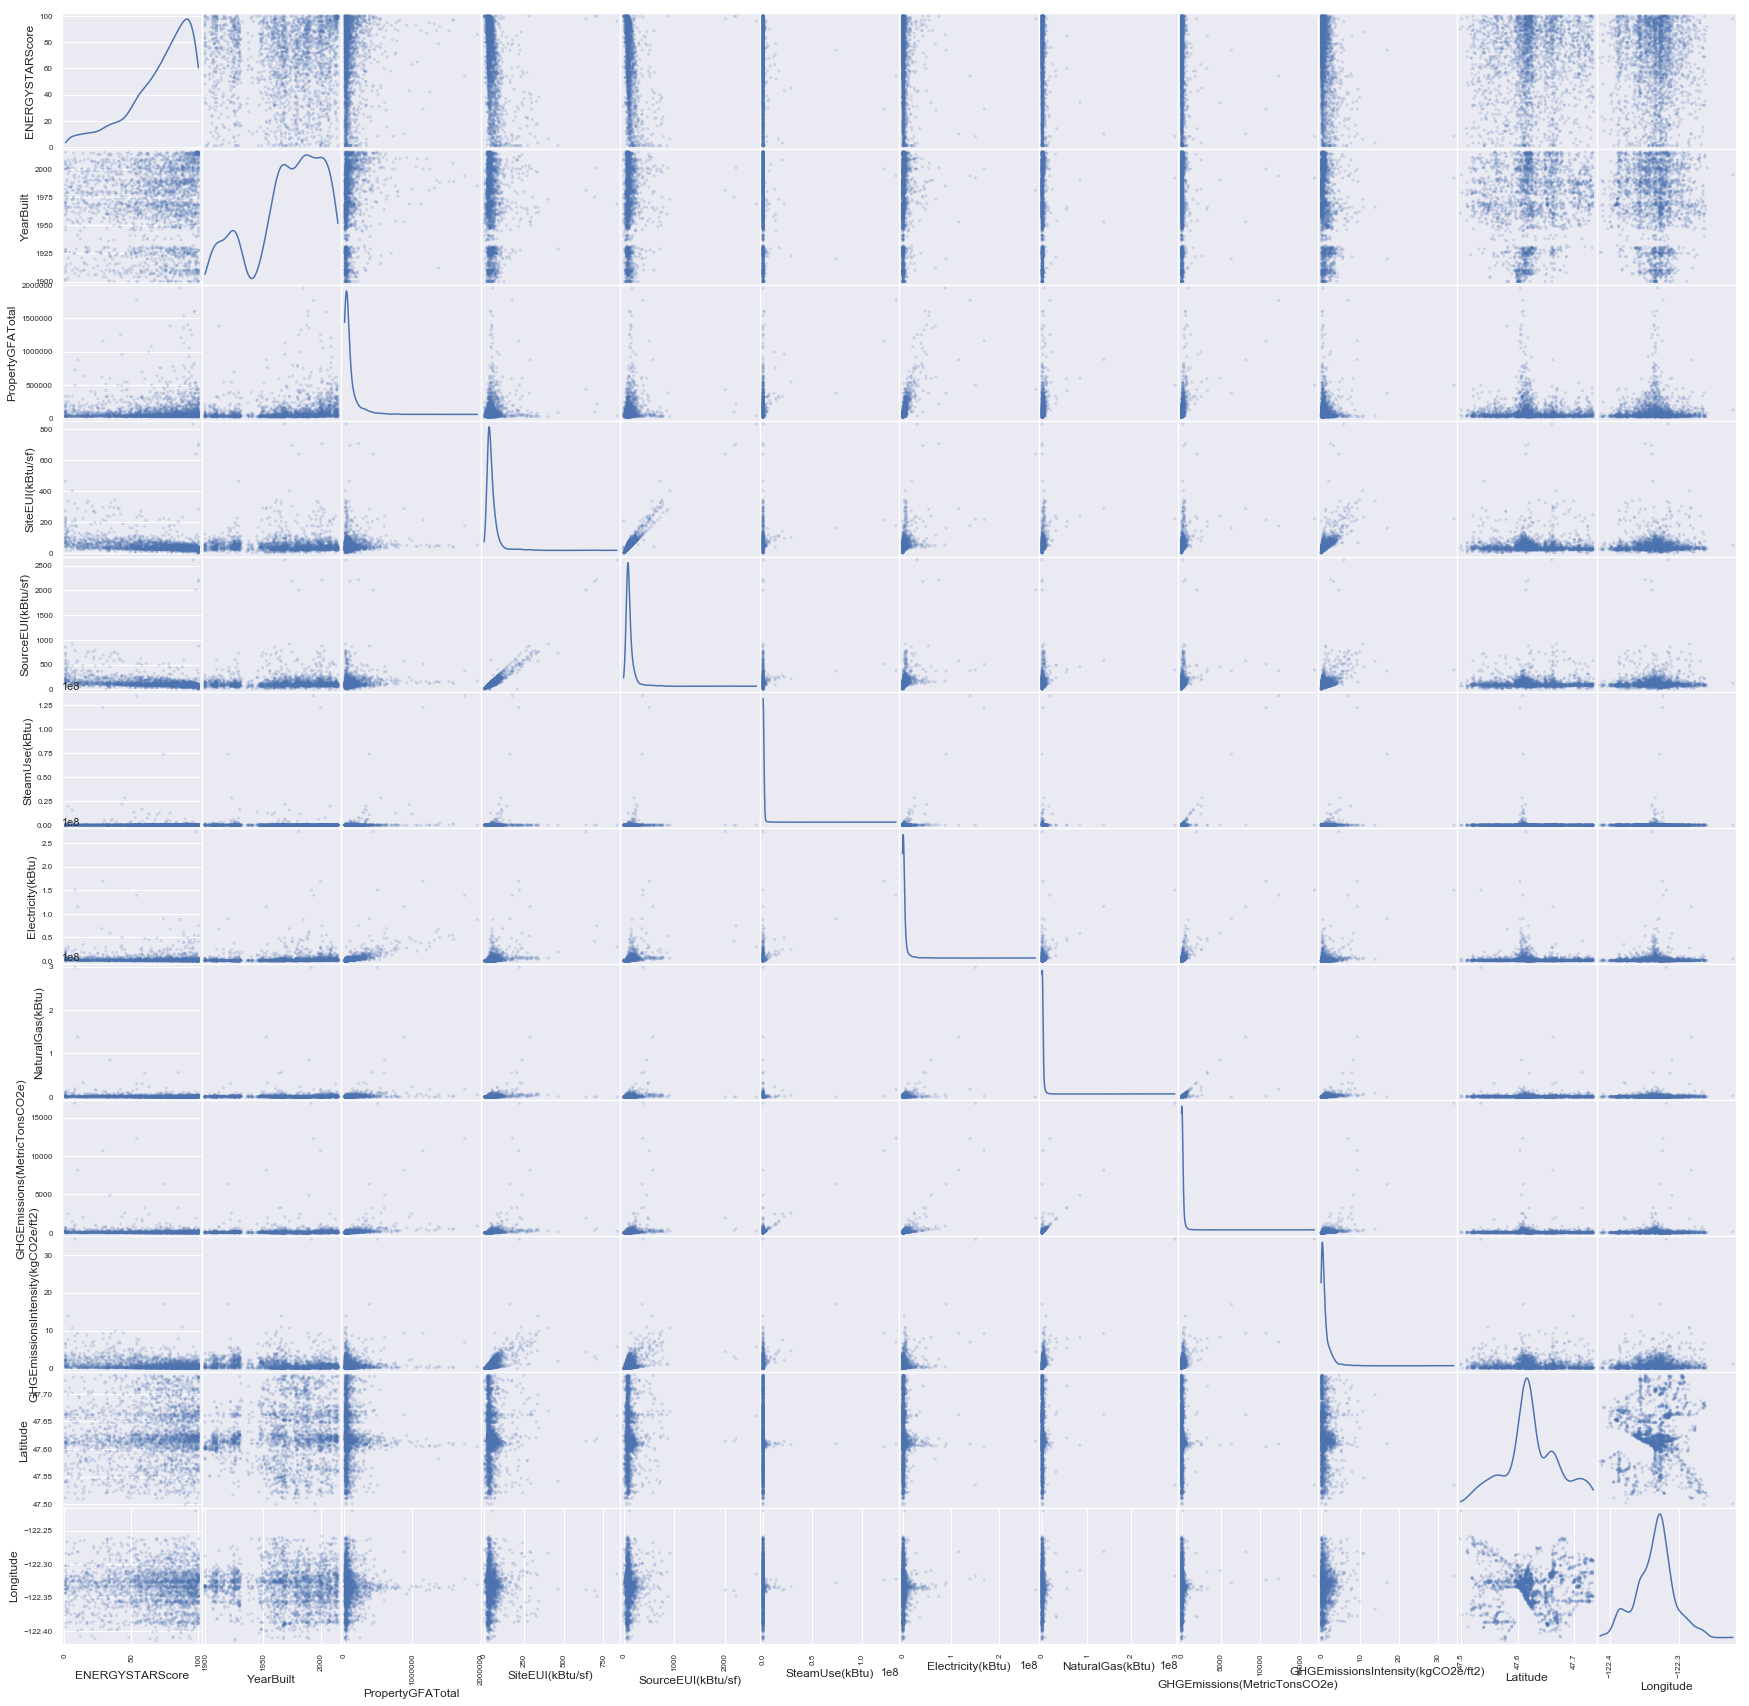

ENERGYSTARScore  YearBuilt  \
ENERGYSTARScore                           1.000000   0.031999   
YearBuilt                                 0.031999   1.000000   
PropertyGFATotal                          0.069818   0.200128   
SiteEUI(kBtu/sf)                         -0.330802  -0.023486   
SourceEUI(kBtu/sf)                       -0.293842   0.044633   
SteamUse(kBtu)                           -0.038705  -0.007224   
Electricity(kBtu)                        -0.053197   0.094381   
NaturalGas(kBtu)                         -0.101404   0.019909   
GHGEmissions(MetricTonsCO2e)             -0.099396   0.021928   
GHGEmissionsIntensity(kgCO2e/ft2)        -0.258418  -0.179651   
Latitude                                  0.088715   0.109438   
Longitude                                -0.024341  -0.065331   

                                   PropertyGFATotal  SiteEUI(kBtu/sf)  \
ENERGYSTARScore                            0.069818         -0.330802   
YearBuilt                                  0.200128         -0.023486   
PropertyGFATotal                           1.000000          0.116003   
SiteEUI(kBtu/sf)                           0.116003          1.000000   
SourceEUI(kBtu/sf)                         0.127225          0.944779   
SteamUse(kBtu)                             0.297492          0.118559   
Electricity(kBtu)                          0.669391          0.450469   
NaturalGas(kBtu)                           0.227399          0.234034   
GHGEmissions(MetricTonsCO2e)               0.414085          0.288441   
GHGEmissionsIntensity(kgCO2e/ft2)          0.067724          0.630642   
Latitude                                  -0.050462         -0.013224   
Longitude                                  0.011989          0.033129   

                                   SourceEUI(kBtu/sf)  SteamUse(kBtu)  \
ENERGYSTARScore                             -0.293842       -0.038705   
YearBuilt                                    0.044633       -0.007224   
PropertyGFATotal                             0.127225        0.297492   
SiteEUI(kBtu/sf)                             0.944779        0.118559   
SourceEUI(kBtu/sf)                           1.000000        0.093083   
SteamUse(kBtu)                               0.093083        1.000000   
Electricity(kBtu)                            0.482801        0.466580   
NaturalGas(kBtu)                             0.143784        0.036172   
GHGEmissions(MetricTonsCO2e)                 0.215395        0.655180   
GHGEmissionsIntensity(kgCO2e/ft2)            0.426256        0.244929   
Latitude                                     0.001984       -0.022516   
Longitude                                    0.019781        0.012959   

                                   Electricity(kBtu)  NaturalGas(kBtu)  \
ENERGYSTARScore                            -0.053197         -0.101404   
YearBuilt                                   0.094381          0.019909   
PropertyGFATotal                            0.669391          0.227399   
SiteEUI(kBtu/sf)                            0.450469          0.234034   
SourceEUI(kBtu/sf)                          0.482801          0.143784   
SteamUse(kBtu)                              0.466580          0.036172   
Electricity(kBtu)                           1.000000          0.436333   
NaturalGas(kBtu)                            0.436333          1.000000   
GHGEmissions(MetricTonsCO2e)                0.698365          0.771939   
GHGEmissionsIntensity(kgCO2e/ft2)           0.340175          0.595991   
Latitude                                   -0.043040         -0.025779   
Longitude                                   0.016820          0.038526   

                                   GHGEmissions(MetricTonsCO2e)  \
ENERGYSTARScore                                       -0.099396   
YearBuilt                                              0.021928   
PropertyGFATotal                                       0.414085   
SiteEUI(kBtu/sf)                                       0.2

In [8]:
# Visualizing numeric features using scatter matrix, alongside correlations
from pandas.plotting import scatter_matrix

dfnumeric_sea2016 = df_sea2016[['ENERGYSTARScore', 'YearBuilt', 
                                'PropertyGFATotal', 'SiteEUI(kBtu/sf)',
                                'SourceEUI(kBtu/sf)', 'SteamUse(kBtu)',
                                'Electricity(kBtu)', 'NaturalGas(kBtu)', 
                                'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
                                'Latitude', 'Longitude']]

scatter_matrix(dfnumeric_sea2016, alpha=0.2, figsize=(30, 30), diagonal='kde')
plt.show()
dfnumeric_sea2016.corr()

Based on the numeric attributes from df_sea2016, ENERGYSTARScore has a moderate negative correlation with both Site Energy Use Intensity (SiteEUI, -0.333) and Source Energy Use Intensity (SourceEUI, -0.293). Both coefficents are noticeably lower than those for df_sea2016 (-0.353, -0.339), whereas Greenhouse Gas Emissions Intensity (GHGEmissionsIntesity) has a slightly stronger negative correlation (-0.258 v. -0.233). Whether this is the result of a change in the feature importance when calculating Energy Star Scores, or simply some normal variance between dataset building samples, remains to be seen. 

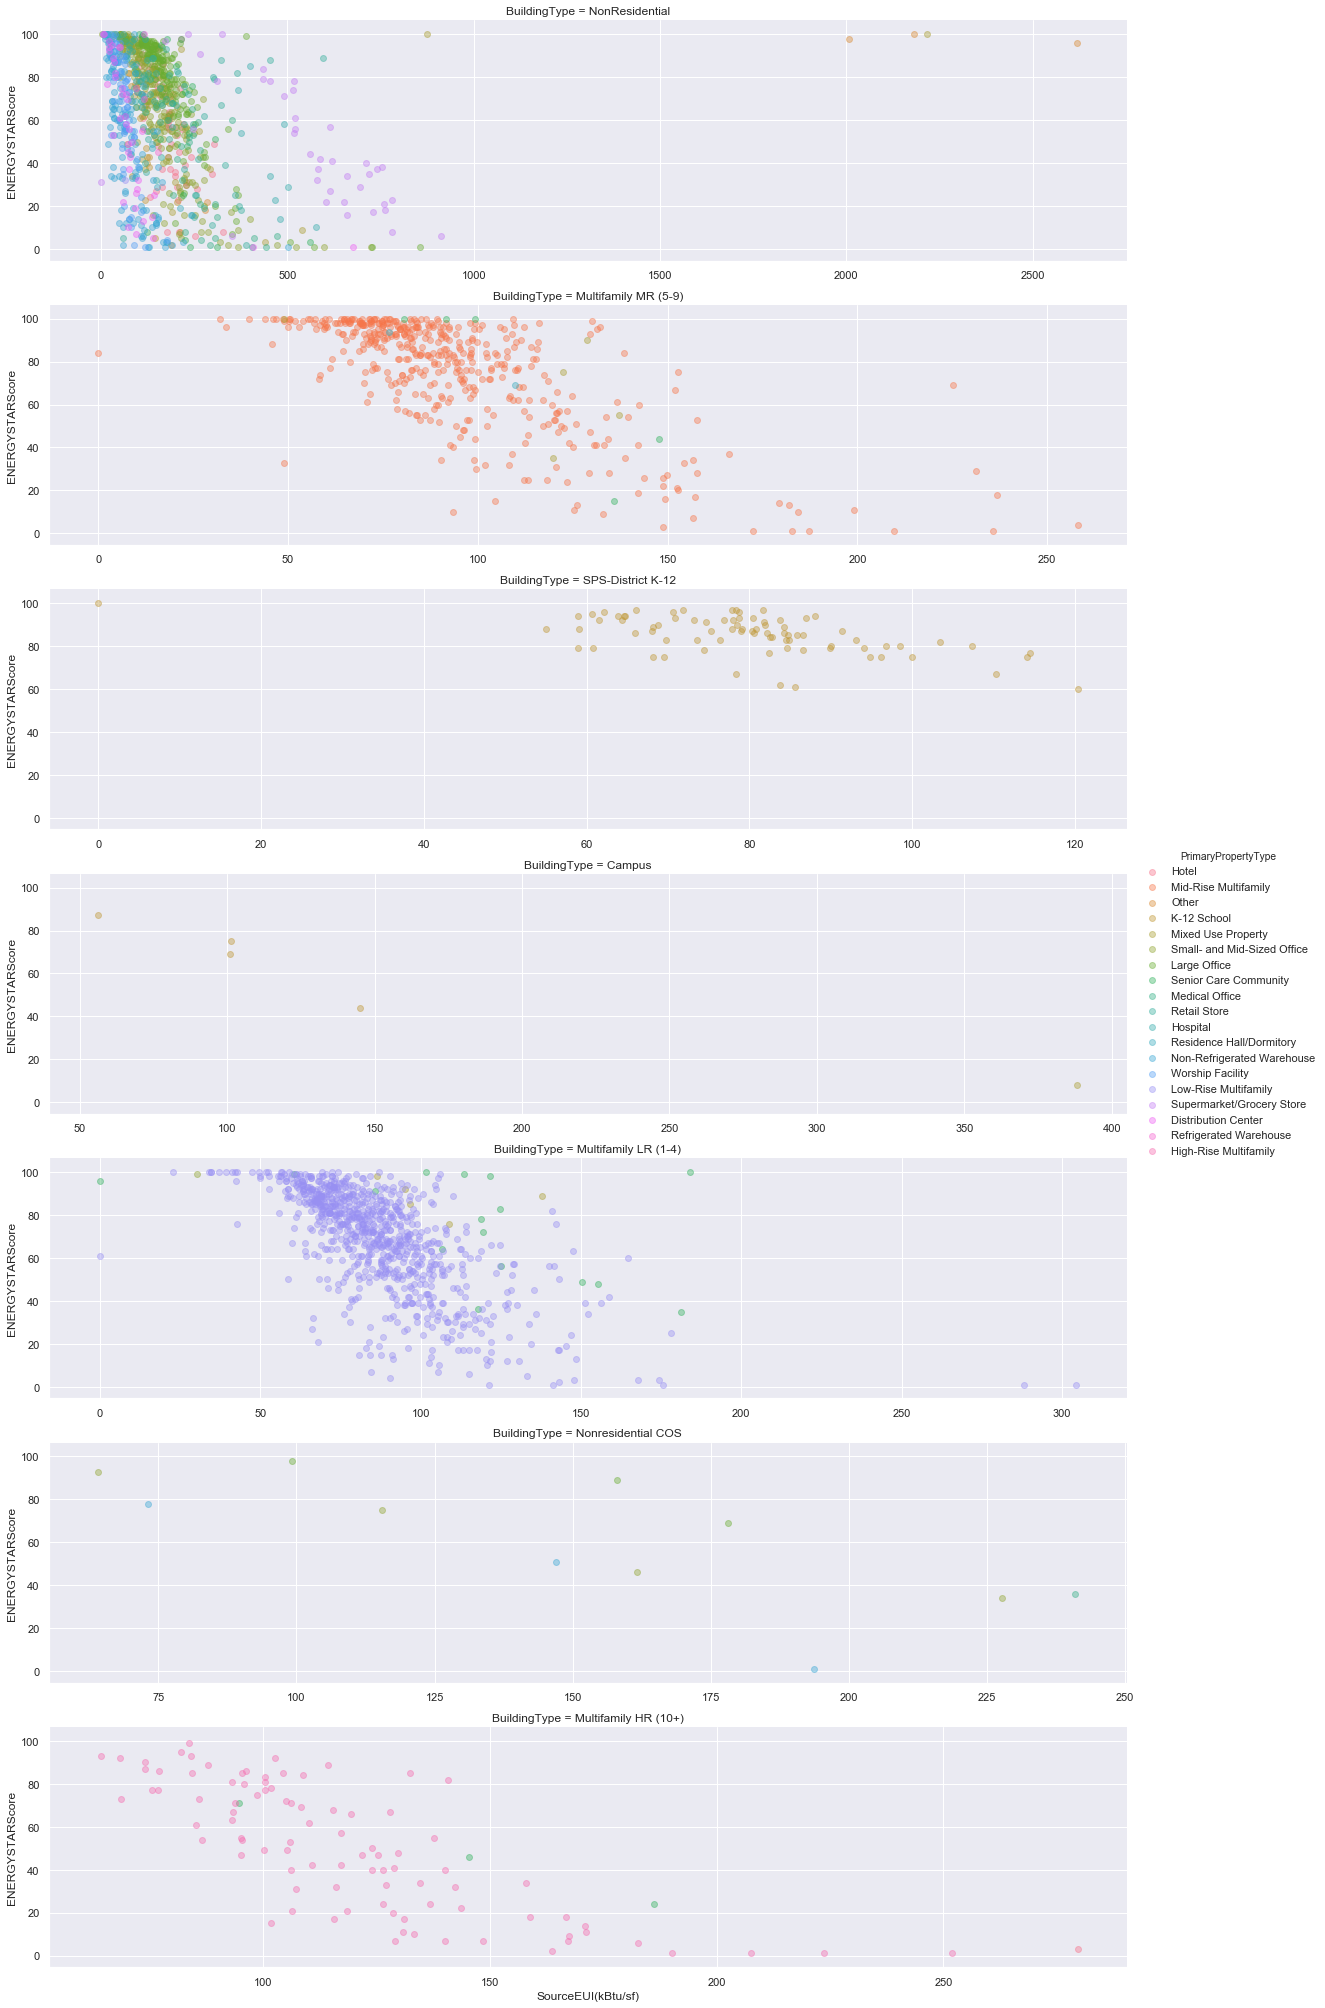

In [9]:
# Visualizing categorical features using facet-grid of BuildingType (rows) and PrimaryPropertyType (hue)
c = sns.FacetGrid(df_sea2016, row="BuildingType", hue="PrimaryPropertyType",
                  height=4, aspect=4, sharex=False)
c = c.map(plt.scatter, "SourceEUI(kBtu/sf)", "ENERGYSTARScore", alpha=0.4).add_legend()
plt.show()

As with df_sea2015, a FacetGrid was created for SourceEUI v. ENERGYSTARScore, with rows representing BuildingType hue representing PrimaryPropertyType. For BuildingType, 44% of entries were NonResidential (2015: 43%), 31% were Multifamily Low-Rise (2015: 30%), 17% were Multifamily Mid-Rise (2015: 17%), 3% High-Rise (2015: 3%), and 6% Other (2015: 6%).

While the overall shape of the data bears many general similarities with the 2015 data, the noticeable traces found in Multifamily MR and LR are not visible. This suggests that these traces were unique to df_sea2015 and are not indicative of a standard scoring practice.

### Chicago Building Energy Benchmarking 2014-2016 Dataset

#### Initial Cleaning

In [10]:
# Removing entries without recorded ENERGY STAR Score values
df_chicago = df_chicago[~df_chicago['ENERGY STAR Score'].isnull()]
df_chicago.reset_index(inplace=True, drop=True)

# Renaming several features to match df_sea2015 and df_sea2016
df_chicago.rename(index=str, columns={'Data Year' : 'DataYear',
                                      'ENERGY STAR Score': 'ENERGYSTARScore',
                                      'Year Built': 'YearBuilt',
                                      '# of Buildings': 'NumberofBuildings',
                                      'Gross Floor Area - Buildings (sq ft)': 'PropertyGFATotal',
                                      'Site EUI (kBtu/sq ft)': 'SiteEUI(kBtu/sf)',
                                      'Source EUI (kBtu/sq ft)': 'SourceEUI(kBtu/sf)',
                                      'Weather Normalized Site EUI (kBtu/sq ft)': 'SiteEUIWN(kBtu/sf)',
                                      'Weather Normalized Source EUI (kBtu/sq ft)': 'SourceEUIWN(kBtu/sf)',
                                      'District Steam Use (kBtu)': 'SteamUse(kBtu)',
                                      'Electricity Use (kBtu)': 'Electricity(kBtu)',
                                      'Natural Gas Use (kBtu)': 'NaturalGas(kBtu)',
                                      'Total GHG Emissions (Metric Tons CO2e)': 'GHGEmissions(MetricTonsCO2e)',
                                      'GHG Intensity (kg CO2e/sq ft)': 'GHGEmissionsIntensity(kgCO2e/ft2)',
                                      'Primary Property Type' : 'PrimaryPropertyType'}, inplace=True)

# Converting 'DataYear' feature from int dtype to str
df_chicago['DataYear'] = df_chicago['DataYear'].astype(str)

# Renaming PrimaryPropertyType value to match df_sea2015 and df_sea2016
df_chicago.loc[df_chicago['PrimaryPropertyType'].str.contains('Hospital'), 'PrimaryPropertyType'] = 'Hospital'

# Creating 'BuildingType' feature to more closely match df_sea2015 and df_sea2016 groupings
df_chicago['BuildingType'] = ''
NonResidential = ['Office', 'Hotel', 'Retail Store',
                  'Supermarket/Grocery Store', 'Hospital', 'Senior Care Community',
                  'Worship Facility', 'Medical Office', 'Wholesale Club/Supercenter',
                  'Mixed Use Property', 'Financial Office', 'Courthouse',
                  'Bank Branch', 'Distribution Center']
df_chicago.loc[df_chicago['PrimaryPropertyType'].isin(NonResidential), 'BuildingType'] = 'NonResidential'
Campus = ['K-12 School', 'Residence Hall/Dormitory']
df_chicago.loc[df_chicago['PrimaryPropertyType'].isin(Campus), 'BuildingType'] = 'Campus'
df_chicago.loc[df_chicago['PrimaryPropertyType'] == 'Multifamily Housing', 'BuildingType'] = 'Multifamily Housing'

# Creating 'SiteEnergyUse(kBtu)' feature as the sum of all energy features
df_chicago['SiteEnergyUse(kBtu)'] = df_chicago['Electricity(kBtu)'].fillna(0) \
                                  + df_chicago['NaturalGas(kBtu)'].fillna(0) \
                                  + df_chicago['SteamUse(kBtu)'].fillna(0) \
                                  + df_chicago['District Chilled Water Use (kBtu)'].fillna(0) \
                                  + df_chicago['All Other Fuel Use (kBtu)'].fillna(0)

# Converting ENERGYSTARScore feature into categorical variable: ENERGYSTARQuintile
bins = [0, 20, 40, 60, 80, np.inf]
names = ['quin0', 'quin1', 'quin2', 'quin3', 'quin4']
df_chicago['ENERGYSTARQuintile'] = pd.cut(df_chicago['ENERGYSTARScore'], bins, labels=names)

print(df_chicago.info())
df_chicago.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 3700 entries, 0 to 3699
Data columns (total 28 columns):
DataYear                             3700 non-null object
ID                                   3700 non-null int64
Property Name                        3700 non-null object
Address                              3700 non-null object
ZIP Code                             3700 non-null object
Community Area                       3700 non-null object
PrimaryPropertyType                  3700 non-null object
PropertyGFATotal                     3700 non-null float64
YearBuilt                            3695 non-null float64
NumberofBuildings                    3700 non-null int64
ENERGYSTARScore                      3700 non-null float64
Electricity(kBtu)                    3695 non-null float64
NaturalGas(kBtu)                     3355 non-null float64
SteamUse(kBtu)                       42 non-null float64
District Chilled Water Use (kBtu)    132 non-null float64
All Other Fuel Use (kBtu) 

ID  PropertyGFATotal    YearBuilt  NumberofBuildings  \
count    3700.000000      3.700000e+03  3695.000000        3700.000000   
mean   184616.107838      3.087945e+05  1962.256834           1.379730   
std     61418.106401      4.192589e+05    36.392618           5.967776   
min    100001.000000      4.457500e+04  1860.000000           1.000000   
25%    117233.250000      8.101350e+04  1927.000000           1.000000   
50%    173640.500000      1.500550e+05  1969.000000           1.000000   
75%    251368.000000      3.585275e+05  1995.000000           1.000000   
max    260184.000000      4.518811e+06  2016.000000         236.000000   

       ENERGYSTARScore  Electricity(kBtu)  NaturalGas(kBtu)  SteamUse(kBtu)  \
count      3700.000000       3.695000e+03      3.355000e+03    4.200000e+01   
mean         59.466757       1.430051e+07      1.384552e+07    4.908798e+07   
std          27.822376       2.964058e+07      2.635117e+07    9.370787e+07   
min           1.000000       2.140000e+02      2.651000e+03   -1.714850e+07   
25%          38.000000       2.242389e+06      3.414875e+06    4.713843e+06   
50%          65.000000       5.114854e+06      6.267428e+06    1.063981e+07   
75%          83.000000       1.271217e+07      1.494254e+07    4.508848e+07   
max         100.000000       4.953688e+08      5.139386e+08    3.654751e+08   

       District Chilled Water Use (kBtu)  All Other Fuel Use (kBtu)  \
count                       1.320000e+02               4.700000e+01   
mean                        2.188824e+07               9.019231e+05   
std                         2.158517e+07               2.356743e+06   
min                        -1.383204e+06               3.450000e+03   
25%                         6.673029e+06               3.229200e+04   
50%                         1.246981e+07               7.009020e+04   
75%                         3.477437e+07               1.244070e+05   
max                         9.075356e+07               1.035900e+07   

       SiteEUI(kBtu/sf)  SourceEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
count       3700.000000         3700.000000         3658.000000   
mean          90.401541          177.075784           94.195626   
std          108.110772          144.118223          109.141302   
min            0.200000            0.200000            0.300000   
25%           62.100000          117.400000           65.100000   
50%           78.650000          150.950000           82.700000   
75%           98.400000          197.325000          103.075000   
max         5637.700000         6001.500000         5637.700000   

       SourceEUIWN(kBtu/sf)  GHGEmissions(MetricTonsCO2e)  \
count           3658.000000                   3674.000000   
mean             180.927255                   3470.923244   
std              144.530117                   6911.552800   
min                0.300000                     32.500000   
25%              121.000000                    657.850000   
50%              156.050000                   1389.250000   
75%              201.200000                   3328.500000   
max             6001.500000                 138008.000000   

       GHGEmissionsIntensity(kgCO2e/ft2)     Latitude    Longitude  \
count                        3674.000000  3700.000000  3700.000000   
mean                           10.249105    41.883448   -87.655066   
std                             8.030710     0.066975     0.049391   
min                             0.400000    41.651404   -87.904210   
25%                             6.600000    41.864810   -87.668298   
50%                             8.600000    41.886961   -87.639352   
75%                            11.700000    41.921737   -87.627307   
max                           304.600000    42.019367   -87.533787   

       SiteEnergyUse(kBtu)  
count         3.700000e+03  
mean          2.818526e+07  
std           5.394337e+07  
min           1.857410e+04  
25%           6.273680e+06  
50%           1.250672e+07  
75%        

The Chicago 2014-2016 building energy benchmarking dataset originally consisted of 4481 entries with 25 attributes. Of this set, 17.4% of entries were missing ENERGYSTARScore values. Removing these entries and creating features such as SiteEnergyUse(kBtu), BuildingType, and the categorical target ENERGYSTARQuintile results in a dataset with 3700 entries and 28 attributes. 

#### Initial Data Exploration

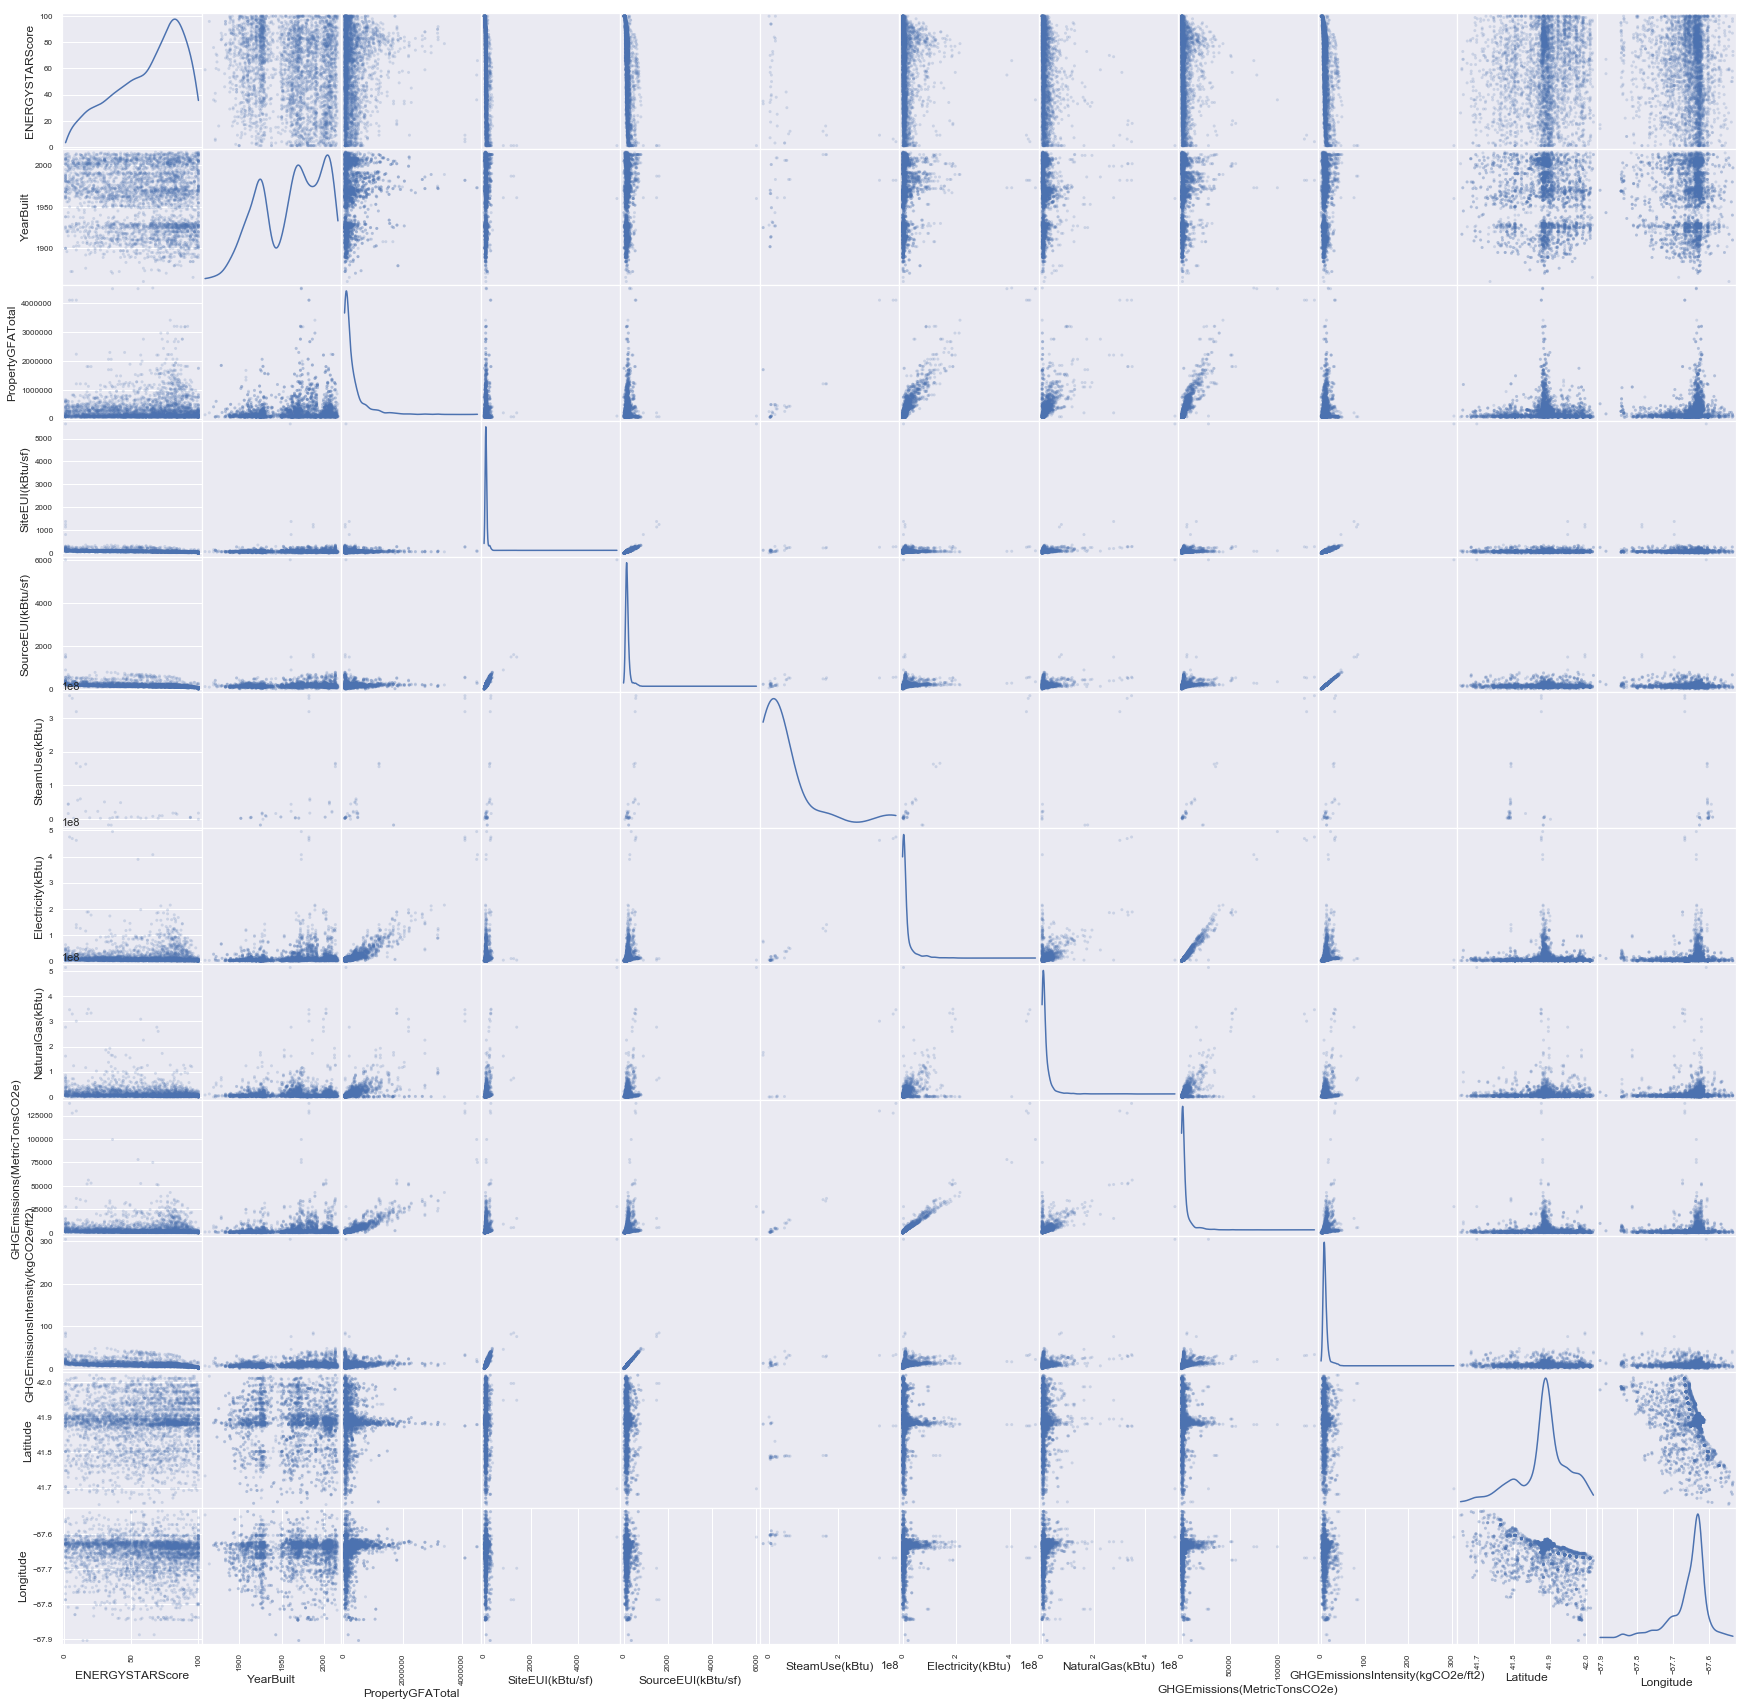

ENERGYSTARScore  YearBuilt  \
ENERGYSTARScore                           1.000000  -0.164839   
YearBuilt                                -0.164839   1.000000   
PropertyGFATotal                          0.069998   0.149323   
SiteEUI(kBtu/sf)                         -0.256030   0.047651   
SourceEUI(kBtu/sf)                       -0.331753   0.146538   
SteamUse(kBtu)                           -0.474919   0.424947   
Electricity(kBtu)                        -0.017767   0.156110   
NaturalGas(kBtu)                         -0.164429   0.060512   
GHGEmissions(MetricTonsCO2e)             -0.058694   0.142784   
GHGEmissionsIntensity(kgCO2e/ft2)        -0.338703   0.164484   
Latitude                                  0.076669  -0.047143   
Longitude                                -0.056109   0.024941   

                                   PropertyGFATotal  SiteEUI(kBtu/sf)  \
ENERGYSTARScore                            0.069998         -0.256030   
YearBuilt                                  0.149323          0.047651   
PropertyGFATotal                           1.000000          0.006002   
SiteEUI(kBtu/sf)                           0.006002          1.000000   
SourceEUI(kBtu/sf)                         0.079701          0.912353   
SteamUse(kBtu)                             0.898697          0.651063   
Electricity(kBtu)                          0.883008          0.074494   
NaturalGas(kBtu)                           0.560466          0.486251   
GHGEmissions(MetricTonsCO2e)               0.872347          0.167676   
GHGEmissionsIntensity(kgCO2e/ft2)          0.106296          0.867372   
Latitude                                   0.028742         -0.037010   
Longitude                                  0.175147         -0.009720   

                                   SourceEUI(kBtu/sf)  SteamUse(kBtu)  \
ENERGYSTARScore                             -0.331753       -0.474919   
YearBuilt                                    0.146538        0.424947   
PropertyGFATotal                             0.079701        0.898697   
SiteEUI(kBtu/sf)                             0.912353        0.651063   
SourceEUI(kBtu/sf)                           1.000000        0.659624   
SteamUse(kBtu)                               0.659624        1.000000   
Electricity(kBtu)                            0.217496        0.960476   
NaturalGas(kBtu)                             0.439555        0.854122   
GHGEmissions(MetricTonsCO2e)                 0.277780        0.959380   
GHGEmissionsIntensity(kgCO2e/ft2)            0.993937        0.654201   
Latitude                                    -0.045014        0.253137   
Longitude                                   -0.027165       -0.683153   

                                   Electricity(kBtu)  NaturalGas(kBtu)  \
ENERGYSTARScore                            -0.017767         -0.164429   
YearBuilt                                   0.156110          0.060512   
PropertyGFATotal                            0.883008          0.560466   
SiteEUI(kBtu/sf)                            0.074494          0.486251   
SourceEUI(kBtu/sf)                          0.217496          0.439555   
SteamUse(kBtu)                              0.960476          0.854122   
Electricity(kBtu)                           1.000000          0.552852   
NaturalGas(kBtu)                            0.552852          1.000000   
GHGEmissions(MetricTonsCO2e)                0.977196          0.698283   
GHGEmissionsIntensity(kgCO2e/ft2)           0.255628          0.426308   
Latitude                                    0.008630          0.015579   
Longitude                                   0.111830          0.095207   

                                   GHGEmissions(MetricTonsCO2e)  \
ENERGYSTARScore                                       -0.058694   
YearBuilt                                              0.142784   
PropertyGFATotal                                       0.872347   
SiteEUI(kBtu/sf)                                       0.1

In [11]:
# Visualizing numeric features using scatter matrix, alongside correlations
from pandas.plotting import scatter_matrix

dfnumeric_chicago = df_chicago[['ENERGYSTARScore', 'YearBuilt', 
                                'PropertyGFATotal', 'SiteEUI(kBtu/sf)',
                                'SourceEUI(kBtu/sf)', 'SteamUse(kBtu)',
                                'Electricity(kBtu)', 'NaturalGas(kBtu)', 
                                'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
                                'Latitude', 'Longitude']]

scatter_matrix(dfnumeric_chicago, alpha=0.2, figsize=(30, 30), diagonal='kde')
plt.show()
dfnumeric_chicago.corr()

As with df_sea2015 and df_sea2016, df_chicago's numeric data shows ENERGYSTARScore being moderately negatively correlated with both SiteEUI (-0.256) and SourceEUI (-0.293), though both coefficients are lower than those of either seattle dataset. Conversely, GHGEmissionsIntensisty has a much stronger negative correlation (-0.339). Another strinking difference is with SteamUse (-0.475), though this is likely the result of a very low sample size (N=42).

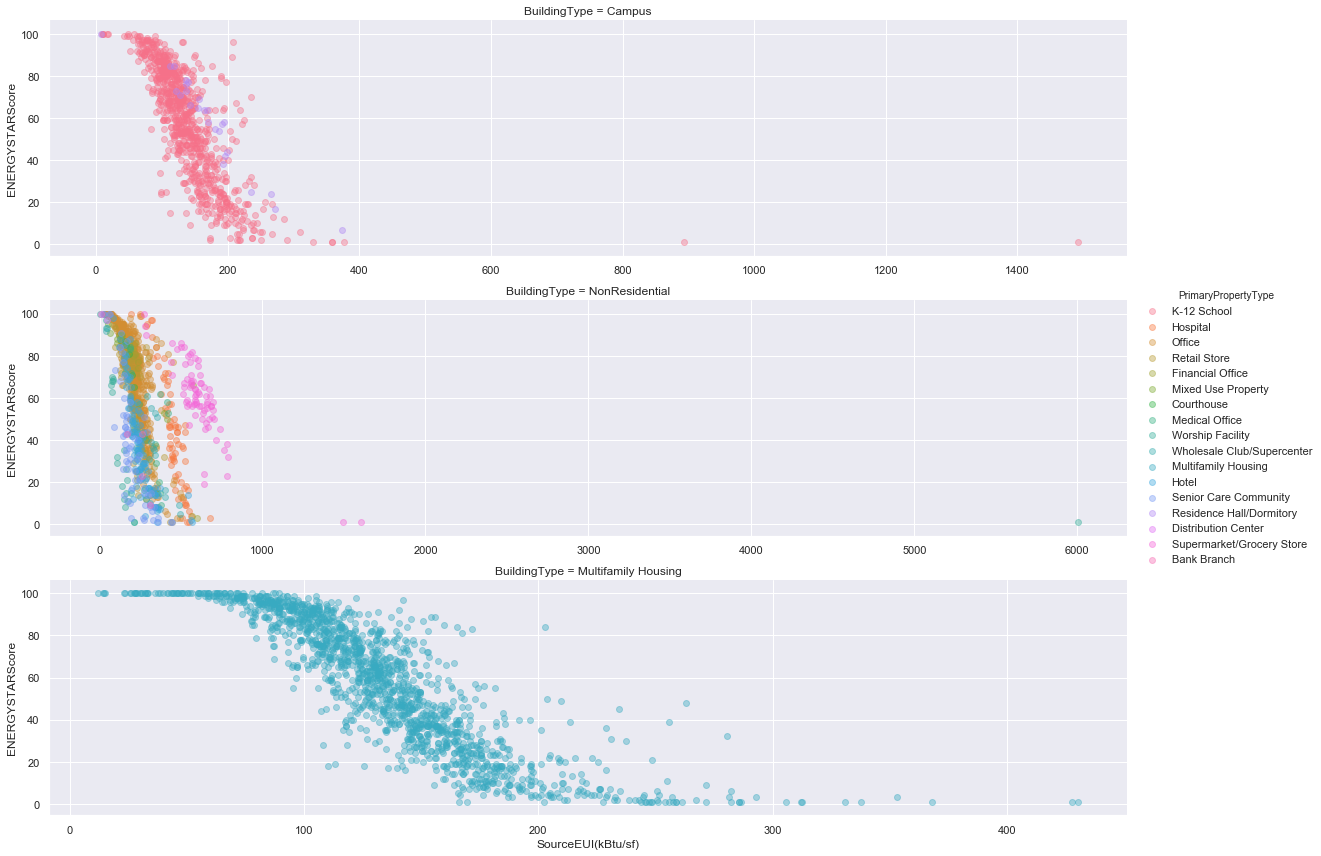

In [12]:
# Visualizing categorical features using facet-grid of BuildingType (rows) and PrimaryPropertyType (hue)
c = sns.FacetGrid(df_chicago, row="BuildingType", hue="PrimaryPropertyType",
                  height=4, aspect=4, sharex=False)
c = c.map(plt.scatter, "SourceEUI(kBtu/sf)", "ENERGYSTARScore", alpha=0.4).add_legend()
plt.show()

Unlike the Seattle datasets, df_chicago did not originally contain a BuildingType feature; rather, buildings were solely categorized by PropertyType (e.g. primary, secondary). A BuildingType feature was created to mimic the faceting of both Seattle datasets, containing three major categories that grouped multiple PrimaryPropertyTypes: Multifamily Housing, Campus, and NonResidential. 

A FacetGrid of SourceEUI v. ENERGYSTARScore (rows representing BuildingType, hue representing PrimaryPropertyType) was created for df_chicago. Unlike either seattle dataset, all facets of the chicago data follow a distinct CDF pattern with limited noise. These were somewhat apparent in the traces of df_sea2015, yet much of the surrounding data did not follow the same pattern. With this data, is clear that we have isolated the groups that are used when evaluating buildings and calculating Energy Star Scores.

## Data Preparation

#### Reducing datasets to useable columns

In [13]:
df_sea2015 = df_sea2015[['DataYear', 'BuildingType', 'PrimaryPropertyType',
                         'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
                         'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
                         'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
                         'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
                         'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
                         'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
                         'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
                         'Latitude', 'Longitude', 'ENERGYSTARQuintile']]

df_sea2016 = df_sea2016[['DataYear', 'BuildingType', 'PrimaryPropertyType',
                         'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
                         'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
                         'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
                         'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
                         'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
                         'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
                         'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
                         'Latitude', 'Longitude', 'ENERGYSTARQuintile']]

df_chicago = df_chicago[['DataYear', 'BuildingType', 'PrimaryPropertyType',
                         'YearBuilt', 'NumberofBuildings', 'PropertyGFATotal',
                         'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
                         'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
                         'Electricity(kBtu)', 'NaturalGas(kBtu)', 'GHGEmissions(MetricTonsCO2e)',
                         'GHGEmissionsIntensity(kgCO2e/ft2)', 'Latitude', 'Longitude',
                         'ENERGYSTARQuintile']]

#### Imputing missing numeric data

In [14]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")

# df_sea2015
df_tar_sea2015 = df_sea2015[['ENERGYSTARQuintile', 'ENERGYSTARScore']].copy()
df_cat_sea2015 = df_sea2015[['DataYear', 'BuildingType', 'PrimaryPropertyType']].copy()
df_num_sea2015 = df_sea2015.drop(df_tar_sea2015, axis=1).copy()
df_num_sea2015 = df_num_sea2015.drop(df_cat_sea2015, axis=1).copy()
df_num_sea2015 = pd.DataFrame(imputer.fit_transform(df_num_sea2015.values), columns=df_num_sea2015.columns)

# df_sea2016
df_tar_sea2016 = df_sea2016[['ENERGYSTARQuintile', 'ENERGYSTARScore']].copy()
df_cat_sea2016 = df_sea2016[['DataYear', 'BuildingType', 'PrimaryPropertyType']].copy()
df_num_sea2016 = df_sea2016.drop(df_tar_sea2016, axis=1).copy()
df_num_sea2016 = df_num_sea2016.drop(df_cat_sea2016, axis=1).copy()
df_num_sea2016 = pd.DataFrame(imputer.fit_transform(df_num_sea2016.values), columns=df_num_sea2016.columns)

# df_chicago
df_tar_chicago = df_chicago[['ENERGYSTARQuintile', 'ENERGYSTARScore']].copy()
df_cat_chicago = df_chicago[['DataYear', 'BuildingType', 'PrimaryPropertyType']].copy()
df_num_chicago = df_chicago.drop(df_tar_chicago, axis=1).copy()
df_num_chicago = df_num_chicago.drop(df_cat_chicago, axis=1).copy()
df_num_chicago = pd.DataFrame(imputer.fit_transform(df_num_chicago.values), columns=df_num_chicago.columns)

#### Winsorizing extreme numeric values

In [15]:
from scipy.stats import mstats

# df_sea2015
for column in df_num_sea2015.columns:
    df_num_sea2015[column] = mstats.winsorize(df_num_sea2015[column].values, limits=0.01)
# df_sea2016
for column in df_num_sea2016.columns:
    df_num_sea2016[column] = mstats.winsorize(df_num_sea2016[column].values, limits=0.01)
# df_chicago
for column in df_num_chicago.columns:
    df_num_chicago[column] = mstats.winsorize(df_num_chicago[column].values, limits=0.01)

#### Normalizing numeric features

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# df_sea2015
df_num_sea2015 = pd.DataFrame(scaler.fit_transform(df_num_sea2015.values), columns=df_num_sea2015.columns)
df_num_sea2015.reset_index(inplace=True, drop=True)
# df_sea2016
df_num_sea2016 = pd.DataFrame(scaler.fit_transform(df_num_sea2016.values), columns=df_num_sea2016.columns)
df_num_sea2016.reset_index(inplace=True, drop=True)
# df_chicago
df_num_chicago = pd.DataFrame(scaler.fit_transform(df_num_chicago.values), columns=df_num_chicago.columns)
df_num_chicago.reset_index(inplace=True, drop=True)

In [17]:
df_num_sea2015.describe()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  2.491000e+03             2491.0    2.491000e+03      2.491000e+03   
mean   2.830645e-15                0.0    8.583727e-16     -1.437808e-16   
std    1.000201e+00                0.0    1.000201e+00      1.000201e+00   
min   -2.181782e+00                0.0   -7.744423e-01     -5.804074e-01   
25%   -5.296414e-01                0.0   -3.794109e-01     -5.047313e-01   
50%    2.098883e-01                0.0   -1.818952e-01     -3.669592e-01   
75%    8.078059e-01                0.0    1.562047e-02      2.117464e-02   
max    1.405723e+00                0.0    5.743575e+00      5.677013e+00   

       PropertyGFAParking  PropertyGFABuilding(s)  SiteEUI(kBtu/sf)  \
count        2.491000e+03            2.491000e+03      2.491000e+03   
mean         2.507250e-15            3.850125e-16     -1.721826e-16   
std          1.000201e+00            1.000201e+00      1.000201e+00   
min         -3.788834e-01           -5.855964e-01     -1.042692e+00   
25%         -3.788834e-01           -5.070538e-01     -5.409698e-01   
50%         -3.788834e-01           -3.517753e-01     -3.086655e-01   
75%         -1.764228e-01            3.636953e-02      2.013042e-01   
max          5.578908e+00            5.782531e+00      5.882449e+00   

       SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
count        2.491000e+03        2.491000e+03          2.491000e+03   
mean         4.011243e-17        3.753855e-17         -1.370341e-16   
std          1.000201e+00        1.000201e+00          1.000201e+00   
min         -1.172050e+00       -1.124503e+00         -1.254175e+00   
25%         -5.520011e-01       -5.154770e-01         -5.119807e-01   
50%         -2.997778e-01       -2.992202e-01         -2.813619e-01   
75%          2.361967e-01        1.368002e-01          1.558771e-01   
max          5.816637e+00        5.635567e+00          5.653851e+00   

           ...       SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  \
count      ...                2.491000e+03    2.491000e+03      2.491000e+03   
mean       ...               -6.028007e-17   -3.334257e-15      2.156712e-16   
std        ...                1.000201e+00    1.000201e+00      1.000201e+00   
min        ...               -5.572614e-01   -1.616986e-01     -5.099682e-01   
25%        ...               -4.542660e-01   -1.616986e-01     -4.164725e-01   
50%        ...               -3.297727e-01   -1.616986e-01     -3.256919e-01   
75%        ...               -2.672457e-02   -1.616986e-01     -6.036591e-02   
max        ...                6.381789e+00    7.775568e+00      6.500550e+00   

       Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  \
count       2.491000e+03        2.491000e+03      2.491000e+03   
mean       -1.112006e-16       -1.410799e-15     -1.564474e-15   
std         1.000201e+00        1.000201e+00      1.000201e+00   
min        -5.099682e-01       -5.356701e-01     -5.356696e-01   
25%        -4.164726e-01       -5.356701e-01     -5.356696e-01   
50%        -3.256918e-01       -3.873235e-01     -3.873025e-01   
75%        -6.036593e-02        6.685614e-02      6.683618e-02   
max         6.500550e+00        5.504444e+00      5.504456e+00   

       GHGEmissions(MetricTonsCO2e)  GHGEmissionsIntensity(kgCO2e/ft2)  \
count                  2.491000e+03                       2.491000e+03   
mean                  -2.355046e-16                      -9.265972e-17   
std                    1.000201e+00                       1.000201e+00   
min                   -5.410801e-01                      -6.990427e-01   
25%                   -4.987031e-01                      -6.537703e-01   
50%                   -3.499314e-01                      -3.821354e-01   
75%                    1.305649e-02                       2.199886e-01   
max                    6.243484e+00                       4.869473e+00   

           Latitude     Longitude  
count  2.491000e+03  2.491

In [18]:
df_num_sea2016.describe()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  2.510000e+03       2.510000e+03    2.510000e+03      2.510000e+03   
mean   2.042589e-15      -4.162783e-17   -8.705741e-16      1.747164e-16   
std    1.000199e+00       1.000199e+00    1.000199e+00      1.000199e+00   
min   -2.175540e+00      -3.445944e+00   -7.910359e-01     -5.992823e-01   
25%   -5.285985e-01      -4.872505e-02   -3.945702e-01     -5.187144e-01   
50%    2.016491e-01      -4.872505e-02   -1.963374e-01     -3.804760e-01   
75%    8.386736e-01      -4.872505e-02    2.001283e-01      2.680502e-02   
max    1.398012e+00       6.745713e+00    5.552415e+00      5.505782e+00   

       PropertyGFAParking  PropertyGFABuilding(s)  SiteEUI(kBtu/sf)  \
count        2.510000e+03            2.510000e+03      2.510000e+03   
mean        -2.806033e-15           -2.593764e-16      2.684882e-17   
std          1.000199e+00            1.000199e+00      1.000199e+00   
min         -2.892040e-01           -6.171461e-01     -1.057039e+00   
25%         -2.892040e-01           -5.284048e-01     -5.389900e-01   
50%         -2.892040e-01           -3.716879e-01     -2.983734e-01   
75%         -2.892040e-01            4.769834e-02      1.841747e-01   
max          5.892110e+00            5.293666e+00      5.632892e+00   

       SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
count        2.510000e+03        2.510000e+03          2.510000e+03   
mean        -1.254862e-16       -2.045066e-16         -2.070500e-16   
std          1.000199e+00        1.000199e+00          1.000199e+00   
min         -1.126816e+00       -1.106391e+00         -1.205911e+00   
25%         -5.479241e-01       -5.033376e-01         -5.052939e-01   
50%         -2.957846e-01       -2.948886e-01         -2.832830e-01   
75%          1.924139e-01        1.250750e-01          1.314533e-01   
max          5.572889e+00        5.521621e+00          5.513542e+00   

           ...       SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  \
count      ...                2.510000e+03    2.510000e+03      2.510000e+03   
mean       ...               -3.725218e-16   -2.820608e-15      3.523078e-16   
std        ...                1.000199e+00    1.000199e+00      1.000199e+00   
min        ...               -5.552593e-01   -1.593690e-01     -5.077358e-01   
25%        ...               -4.571783e-01   -1.593690e-01     -4.169509e-01   
50%        ...               -3.382302e-01   -1.593690e-01     -3.277422e-01   
75%        ...               -2.046527e-02   -1.593690e-01     -5.364552e-02   
max        ...                6.159158e+00    7.970768e+00      6.469040e+00   

       Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  \
count       2.510000e+03        2.510000e+03      2.510000e+03   
mean       -2.868887e-16        2.133530e-15     -1.635301e-15   
std         1.000199e+00        1.000199e+00      1.000199e+00   
min        -5.077358e-01       -5.452074e-01     -5.452074e-01   
25%        -4.169510e-01       -5.452074e-01     -5.452074e-01   
50%        -3.277422e-01       -3.813255e-01     -3.813255e-01   
75%        -5.364547e-02        8.655202e-02      8.655203e-02   
max         6.469040e+00        5.585549e+00      5.585549e+00   

       GHGEmissions(MetricTonsCO2e)  GHGEmissionsIntensity(kgCO2e/ft2)  \
count                  2.510000e+03                       2.510000e+03   
mean                  -4.354197e-16                       1.743625e-16   
std                    1.000199e+00                       1.000199e+00   
min                   -5.646492e-01                      -7.761764e-01   
25%                   -5.183396e-01                      -6.576216e-01   
50%                   -3.568382e-01                      -3.527663e-01   
75%                    3.138171e-02                       2.040178e-01   
max                    5.861291e+00                       4.812836e+00   

           Latitude     Longitude  
count  2.510000e+03  2.510

In [19]:
df_num_chicago.describe()

YearBuilt  NumberofBuildings  PropertyGFATotal  SiteEUI(kBtu/sf)  \
count  3.700000e+03       3.700000e+03      3.700000e+03      3.700000e+03   
mean  -1.140259e-15      -5.638283e-16     -3.587821e-16      3.066616e-17   
std    1.000135e+00       1.000135e+00      1.000135e+00      1.000135e+00   
min   -2.056638e+00      -1.859172e-01     -6.825895e-01     -1.558829e+00   
25%   -9.777895e-01      -1.859172e-01     -5.993884e-01     -5.719481e-01   
50%    1.840472e-01      -1.859172e-01     -4.107621e-01     -2.040905e-01   
75%    9.032794e-01      -1.859172e-01      1.587996e-01      2.348936e-01   
max    1.428872e+00       7.648862e+00      4.792563e+00      4.313556e+00   

       SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
count        3.700000e+03        3.700000e+03          3.700000e+03   
mean        -1.547411e-16       -6.522560e-17          7.745306e-17   
std          1.000135e+00        1.000135e+00          1.000135e+00   
min         -1.611052e+00       -1.382896e+00         -1.405912e+00   
25%         -5.716324e-01       -5.798031e-01         -5.789927e-01   
50%         -1.923183e-01       -2.387428e-01         -2.249645e-01   
75%          2.477517e-01        2.326931e-01          2.256400e-01   
max          4.289390e+00        4.514246e+00          4.541351e+00   

       SiteEnergyUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  \
count         3.700000e+03       3.700000e+03      3.700000e+03   
mean          7.488004e-17      -8.982304e-17      4.193642e-16   
std           1.000135e+00       1.000135e+00      1.000135e+00   
min          -6.778776e-01      -5.891425e-01     -7.169126e-01   
25%          -5.555481e-01      -5.027414e-01     -5.071080e-01   
50%          -3.829856e-01      -3.737502e-01     -3.520265e-01   
75%           1.042342e-01      -3.257122e-02      8.348159e-02   
max           4.914195e+00       5.007453e+00      5.645083e+00   

       GHGEmissions(MetricTonsCO2e)  GHGEmissionsIntensity(kgCO2e/ft2)  \
count                  3.700000e+03                       3.700000e+03   
mean                  -6.044714e-17                       3.280803e-16   
std                    1.000135e+00                       1.000135e+00   
min                   -6.125876e-01                      -1.313821e+00   
25%                   -5.200384e-01                      -5.901981e-01   
50%                   -3.742676e-01                      -2.536295e-01   
75%                    1.024877e-02                       2.680519e-01   
max                    5.138044e+00                       4.525645e+00   

           Latitude     Longitude  
count  3.700000e+03  3.700000e+03  
mean  -5.280230e-14 -1.244289e-13  
std    1.000135e+00  1.000135e+00  
min   -2.865774e+00 -3.751946e+00  
25%   -2.820757e-01 -2.715025e-01  
50%    5.099872e-02  3.226813e-01  
75%    5.739296e-01  5.699503e-01  
max    1.906575e+00  1.987474e+00

#### One hot encoding categorical features

In [20]:
# df_sea2015
df_cat_sea2015 = pd.get_dummies(df_cat_sea2015)
df_cat_sea2015.reset_index(inplace=True, drop=True)
# df_sea2016
df_cat_sea2016 = pd.get_dummies(df_cat_sea2016)
df_cat_sea2016.reset_index(inplace=True, drop=True)
# df_chicago
df_cat_chicago = pd.get_dummies(df_cat_chicago)
df_cat_chicago.reset_index(inplace=True, drop=True)

#### Recombining categorical and numerical data

In [21]:
# df_sea2015
df_sea2015 = pd.concat([df_num_sea2015, df_cat_sea2015], axis=1)
# df_sea2016
df_sea2016 = pd.concat([df_num_sea2016, df_cat_sea2016], axis=1)
# df_chicago
df_chicago = pd.concat([df_num_chicago, df_cat_chicago], axis=1)
df_chicago.head()

YearBuilt  NumberofBuildings  PropertyGFATotal  SiteEUI(kBtu/sf)  \
0  -0.977789          -0.185917          0.053267         -0.174084   
1   0.764966          -0.185917          0.401414          0.181549   
2  -0.064918          -0.185917         -0.137705         -0.085176   
3  -0.784150          -0.185917          0.062829         -0.062949   
4  -0.950127          -0.185917         -0.005386          0.025959   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           -0.360902           -0.461881             -0.573869   
1            0.033190            0.951156              0.850441   
2           -0.251432           -0.360223             -0.440660   
3           -0.251432           -0.329726             -0.430414   
4           -0.273326           -0.187406             -0.327945   

   SiteEnergyUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  \
0            -0.019914          -0.293966          0.384140   
1             0.460476           1.005639         -0.298115   
2            -0.145899          -0.332712          0.166265   
3             0.028570          -0.235722          0.411066   
4             0.003954          -0.201317          0.313359   

                   ...                   PrimaryPropertyType_Medical Office  \
0                  ...                                                    0   
1                  ...                                                    0   
2                  ...                                                    0   
3                  ...                                                    0   
4                  ...                                                    0   

   PrimaryPropertyType_Mixed Use Property  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   

   PrimaryPropertyType_Multifamily Housing  PrimaryPropertyType_Office  \
0                                        0                           0   
1                                        0                           0   
2                                        0                           0   
3                                        0                           0   
4                                        0                           0   

   PrimaryPropertyType_Residence Hall/Dormitory  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   PrimaryPropertyType_Retail Store  \
0                                 0   
1                                 0   
2                                 0   
3                                 0   
4                                 0   

   PrimaryPropertyType_Senior Care Community  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   PrimaryPropertyType_Supermarket/Grocery Store  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   PrimaryPropertyType_Wholesale Club/Supercenter  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   PrimaryPropertyType_Worship Facility  
0                                     0  
1                                     0  
2             

#### Combining seattle data into single dataframe

In [22]:
df_seattle = pd.concat([df_sea2015, df_sea2016], axis=0, sort=True).fillna(0)
df_seattle.head()

BuildingType_Campus  BuildingType_Multifamily HR (10+)  \
0                    0                                  0   
1                    0                                  0   
2                    0                                  0   
3                    0                                  0   
4                    0                                  0   

   BuildingType_Multifamily LR (1-4)  BuildingType_Multifamily MR (5-9)  \
0                                  0                                  0   
1                                  0                                  0   
2                                  0                                  0   
3                                  0                                  0   
4                                  0                                  0   

   BuildingType_NonResidential  BuildingType_Nonresidential COS  \
0                            1                                0   
1                            1                                0   
2                            1                                0   
3                            1                                0   
4                            1                                0   

   BuildingType_SPS-District K-12  DataYear_2015  DataYear_2016  \
0                               0            1.0            0.0   
1                               0            1.0            0.0   
2                               0            1.0            0.0   
3                               0            1.0            0.0   
4                               0            1.0            0.0   

   Electricity(kBtu)    ...      PropertyGFAParking  PropertyGFATotal  \
0           0.116982    ...               -0.378883         -0.017431   
1           0.155656    ...                0.144430          0.107754   
2           6.500550    ...               -0.378883          5.677013   
3           0.536809    ...                0.053968          0.242801   
4          -0.060550    ...               -0.378883         -0.062319   

   SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
0          0.878973            0.777426             0.393692   
1          1.305093            1.268736             0.583911   
2          1.365575            1.287127             6.213249   
3          2.011628            1.875648             1.481082   
4          0.823990            0.759035             0.292737   

   SiteEnergyUseWN(kBtu)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0               0.374094            0.651141              0.595458   
1               0.600704            0.859215              0.830759   
2               6.381789            1.460058              1.431304   
3               1.458168            1.297573              1.204197   
4               0.289869            0.370591              0.397617   

   SteamUse(kBtu)  YearBuilt  
0        4.742306  -1.332110  
1       -0.161699   0.839275  
2        7.775568  -0.010397  
3       -0.161699   0.335766  
4       -0.161699  -1.363579  

[5 rows x 51 columns]

## Code Output

In [23]:
df_seattle.to_csv('Energy_Benchmarking_Seattle_df_clean.csv')
df_chicago.to_csv('Energy_Benchmarking_Chicago_df_clean.csv')

## Machine Learning Model(s)

With the creation of ENERGYSTARQuintile, containing 5 quintile categories that represent the binning of ENERGYSTARScore, either multiclass classification or regression models can be utilized. For classification, Naive Bayes and Decision Trees extend well from binary to multiclass classfication: both would make excellent initial models, as they are relatively simple and would allow us to determine the importance of underlying features in the model. ENERGYSTARQuintile could also be transformed to a binary feature (e.g. top quintile v. lower quintiles), allowing the use of other classification algorithms, such as Support Vector Machines.

If we were to focus on the original target ENERGYSTARScore, a continuous variable, a regression model would prove more effective. Many of classification algorithms mentioned have regressor variants that allow for their use with continuous variables, including Regression Trees (CART) and Support Vector Regressors. Linear Regression would likely be the best place to start however, given its widespread use and ability to extend into Lasso, Ridge, and ElasticNet Regression.